## Phase 3 (Data Preparation)

Datan esikäsittelyvaiheessa on tarkoitus käsitellä ja valmistella data sellaiseen kuntoon, että sitä voidaan käyttää helposti mallinnusvaiheessa ilman merkittäviä lisämuokkauksia.   
   
Vaiheessa keskitytyään esimerkiksi tietojen: 
- Puhdistamiseen 
- Muokkaamiseen 
- Valitsemiseen   

- Lopuksi data skaalataan ja/tai normalisoidaan. 

Vaiheessa on paljon tekemistä, mutta sen onnistuminen on tärkeä myös koko projektin onnistumisen kannalta. Datan esikäsittelyvaiheeseen saatetaan joutua palaamaan takaisin vielä myöhemmässä vaiheessa projektia. 


## Sisällysluettelo

1. [Datan lataaminen](#datan-lataaminen)
2. [Sarakkeiden poistoja](#sarakkeiden-poistoja)
3. [Datatyyppien muutoksia](#datatyyppien-muutoksia)
4. [Kategoriset sarakkeet](#kategoriset-sarakkeet)
5. [NaN-arvojen käsittely](#nan-arvojen-kasittely)
6. [One-Hot Encoding](#one-hot-encoding)
7. [Outliers](#poikkeavien-arvojen-tunnistaminen-outliers)
8. [Datan visualisointeja](#datan-visualisointeja)
9. [LabelEncoding](#Label-encoding)
9. [Mallille vietävien sarakkeiden viimeistelyt](#Mallille-vietavien-sarakkeiden-viimeistelyt)
10. [Datan skaalaaminen](#datan-skaalaaminen)
11. [Luokkamuuttujan valitseminen](#Luokkamuuttujan-valitseminen)


### Tästä lähtee datan esikäsittelyvaiheen toteutus

## Datan lataaminen

- Ladataan esikäsittelemätön data

'''#import kaggle
#import zipfile
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

file_path = r"C:\Lataukset\used_cars\used_cars_data.csv"

# Get the total number of rows
total_rows = sum(1 for _ in open(file_path, encoding='ISO-8859-1'))  # Count rows for progress

# Create an empty dataframe to accumulate chunks
dataframe = pd.DataFrame()


# Read in chunks and display a progress bar
#Poista nrows=1000000 jos haluat ladata kaikki rivit
chunk_size = 10000
for chunk in tqdm(pd.read_csv(file_path, nrows=1000000, chunksize=chunk_size), total=total_rows // chunk_size, desc="Loading CSV"):
    dataframe = pd.concat([dataframe, chunk])


print("Data loaded successfully.")'''

In [1]:
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


file_path = r"C:\Users\Omistaja\Desktop\AI_DA-projekti1\aida-projekti-syksy-2024-ryhma-1\docs\us_used_cars\used_cars_data.csv"
#file_path = r"D:\Koulu\AIDA_S24\AIDA_project\aida-projekti-local\archive\used_cars_data.csv"
dataframe = pd.read_csv(file_path, nrows=1000000)


## Sarakkeiden poistoja:

- Poistetaan sarakkeita, joilla ei katsota olevan arvoa lopputuloksen kannalta
- Poistetaan sarakkeet, joissa liikaa NaN-arvoja, niiden korvaaminen muulla tavalla vääristäisi dataa
- Poistetaan toinen sellaisista sarakkeista, jotka sisältävät saman tiedon

In [2]:

# Näillä sarakkeilla ei katsota olevan arvoa lopputuloksen kannalta
dataframe.drop(columns=[
    'vin',
    'description',
    'listing_id',
    'main_picture_url',
    'bed',
    'bed_height',
    'bed_length',
    'cabin',
    'combine_fuel_economy',
    'is_certified',
    'is_cpo',
    'is_oemcpo',
    'latitude',
    'longitude',
    'vehicle_damage_category',
    'engine_type',
    'engine_cylinders'
    ],axis=1,inplace=True)

#`trim_name` ja `trimId` sisältävät samaa tietoa, joten pudotetaan `trimId`-sarake.
# `wheel_system` ja `wheel_system_display` sisältävät saman tiedon, joten poistetaan `wheel_system`.
dataframe.drop(columns=[
    'trimId', 
    'wheel_system'
    ],axis=1, inplace=True)

dataframe.info()
dataframe.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 47 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   back_legroom          951854 non-null   object 
 1   body_type             995631 non-null   object 
 2   city                  1000000 non-null  object 
 3   city_fuel_economy     836741 non-null   float64
 4   daysonmarket          1000000 non-null  int64  
 5   dealer_zip            1000000 non-null  object 
 6   engine_displacement   948298 non-null   float64
 7   exterior_color        984313 non-null   object 
 8   fleet                 536735 non-null   object 
 9   frame_damaged         536735 non-null   object 
 10  franchise_dealer      1000000 non-null  bool   
 11  franchise_make        803215 non-null   object 
 12  front_legroom         951854 non-null   object 
 13  fuel_tank_volume      951854 non-null   object 
 14  fuel_type             975236 non-nu

,back_legroom,body_type,city,city_fuel_economy,daysonmarket,dealer_zip,engine_displacement,exterior_color,fleet,frame_damaged,...,sp_name,theft_title,torque,transmission,transmission_display,trim_name,wheel_system_display,wheelbase,width,year
0,35.1 in,SUV / Crossover,Bayamon,NaN,522,960,1300.0,Solar Yellow,NaN,NaN,...,Flagship Chrysler,NaN,"200 lb-ft @ 1,750 RPM",A,9-Speed Automatic Overdrive,Latitude FWD,Front-Wheel Drive,101.2 in,79.6 in,2019
1,38.1 in,SUV / Crossover,San Juan,NaN,207,922,2000.0,Narvik Black,NaN,NaN,...,Land Rover San Juan,NaN,"269 lb-ft @ 1,400 RPM",A,9-Speed Automatic Overdrive,S AWD,All-Wheel Drive,107.9 in,85.6 in,2020
2,35.4 in,Sedan,Guaynabo,17.0,1233,969,2500.0,NaN,False,False,...,FIAT de San Juan,False,"290 lb-ft @ 4,000 RPM",M,6-Speed Manual,Base,All-Wheel Drive,104.3 in,78.9 in,2016
3,37.6 in,SUV / Crossover,San Juan,NaN,196,922,3000.0,Eiger Gray,NaN,NaN,...,Land Rover San Juan,NaN,"332 lb-ft @ 3,500 RPM",A,8-Speed Automatic Overdrive,V6 HSE AWD,All-Wheel Drive,115 in,87.4 in,2020
4,38.1 in,SUV / Crossover,San Juan,NaN,137,922,2000.0,Narvik Black,NaN,NaN,...,Land Rover San Juan,NaN,"269 lb-ft @ 1,400 RPM",A,9-Speed Automatic Overdrive,S AWD,All-Wheel Drive,107.9 in,85.6 in,2020


### Tietotyyppien jakauman havainnollistaminen pylväs- ja piirakkakaavioina

- Pyrkimys päästä eroon objekti-tyyppisestä datasta, koska mallintamisvaiheessa datan tulee olla numeerista
- Eroon objekteista päästään mm. tietotyyppien muunnoksilla ja osittain sarakkeiden/rivien poistoilla

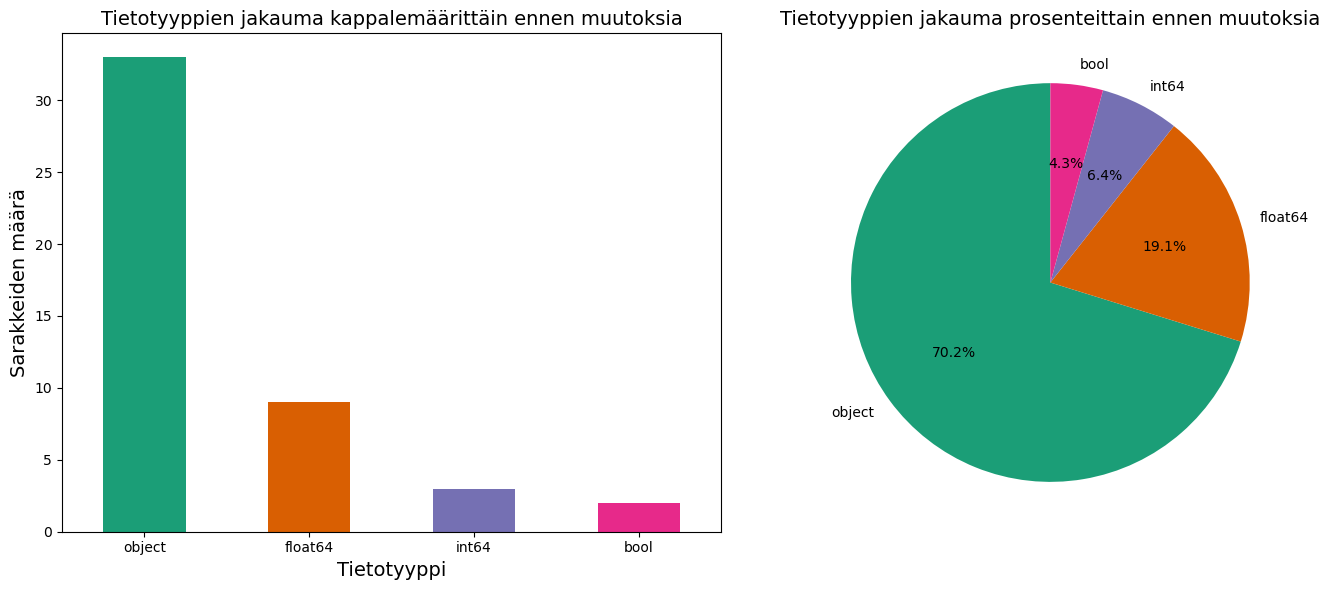

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm

data_types_plot1 = dataframe.dtypes.value_counts()
colors = cm.Dark2.colors

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Barplot
data_types_plot1.plot(
    kind="bar",
    ax=axes[0],
    color=colors
)

axes[0].tick_params(axis="x", rotation=0)
axes[0].set_title("Tietotyyppien jakauma kappalemäärittäin ennen muutoksia", fontsize=14)
axes[0].set_xlabel("Tietotyyppi", fontsize=14)
axes[0].set_ylabel("Sarakkeiden määrä", fontsize=14)

# Pie
data_types_plot1.plot(
    kind="pie",
    ax=axes[1],
    autopct="%1.1f%%",
    startangle=90,
    ylabel="",
    colors=colors
)

axes[1].set_title("Tietotyyppien jakauma prosenteittain ennen muutoksia", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

## Datatyyppien muutoksia:

- Muutetaan objekti-tyyppiset sarakkeet numeeriseksi ja booleaniksi kun mahdollista
- Päivämäärän käsittely
- Sarakkeiden "power" ja "torque" jakaminen kahteen sarakkeeseen, sillä sisältävät kaksi arvoa

In [4]:
# Preprosessataan nämä objekti-kolumnit numeriseksi:

# back_legroom numeriseksi
dataframe['back_legroom'] = dataframe['back_legroom'].astype(str).apply(lambda x: x.split()[0])
dataframe['back_legroom'] = pd.to_numeric(dataframe['back_legroom'], errors='coerce')

# dealer_zip numeriseksi
dataframe['dealer_zip'] = pd.to_numeric(dataframe['dealer_zip'], errors='coerce')
#print(dataframe['dealer_zip'].dtype) - float64

# front_legroom numeriseksi
dataframe['front_legroom'] = dataframe['front_legroom'].astype(str).apply(lambda x: x.split()[0])
dataframe['front_legroom'] = pd.to_numeric(dataframe['front_legroom'], errors='coerce')

# fuel_tank_volume numeriseksi
dataframe['fuel_tank_volume'] = dataframe['fuel_tank_volume'].astype(str).apply(lambda x: x.split()[0])
dataframe['fuel_tank_volume'] = pd.to_numeric(dataframe['fuel_tank_volume'], errors='coerce')

# height numeriseksi
dataframe['height'] = dataframe['height'].astype(str).apply(lambda x: x.split()[0])
dataframe['height'] = pd.to_numeric(dataframe['height'], errors='coerce')

# lenght numeriseksi
dataframe['length'] = dataframe['length'].astype(str).apply(lambda x: x.split()[0])
dataframe['length'] = pd.to_numeric(dataframe['length'], errors='coerce')

# maximum_seating numeriseksi
dataframe['maximum_seating'] = dataframe['maximum_seating'].astype(str).apply(lambda x: x.split()[0])
dataframe['maximum_seating'] = pd.to_numeric(dataframe['maximum_seating'], errors='coerce')

# wheelbase numeriseksi
dataframe['wheelbase'] = dataframe['wheelbase'].astype(str).apply(lambda x: x.split()[0])
dataframe['wheelbase'] = pd.to_numeric(dataframe['wheelbase'], errors='coerce')

# width numeriseksi
dataframe['width'] = dataframe['width'].astype(str).apply(lambda x: x.split()[0])
dataframe['width'] = pd.to_numeric(dataframe['width'], errors='coerce')




#### Histogrammi datatyppien muutoksista

Muutimme arvot numeerisiksi, jolloin histogrammi ryhmitteli arvot loogisiin luokkiin, ja voimme nähdä numeerisen jakauman.

Tämä selkeyttää ja yhtenäistää datan visualisointia sekä tekee sen käyttökelpoiseksi jatkoanalyysissä. Kuvissa näytetty 30 isointa ryhmää luettavuuden säilyttämiseksi.

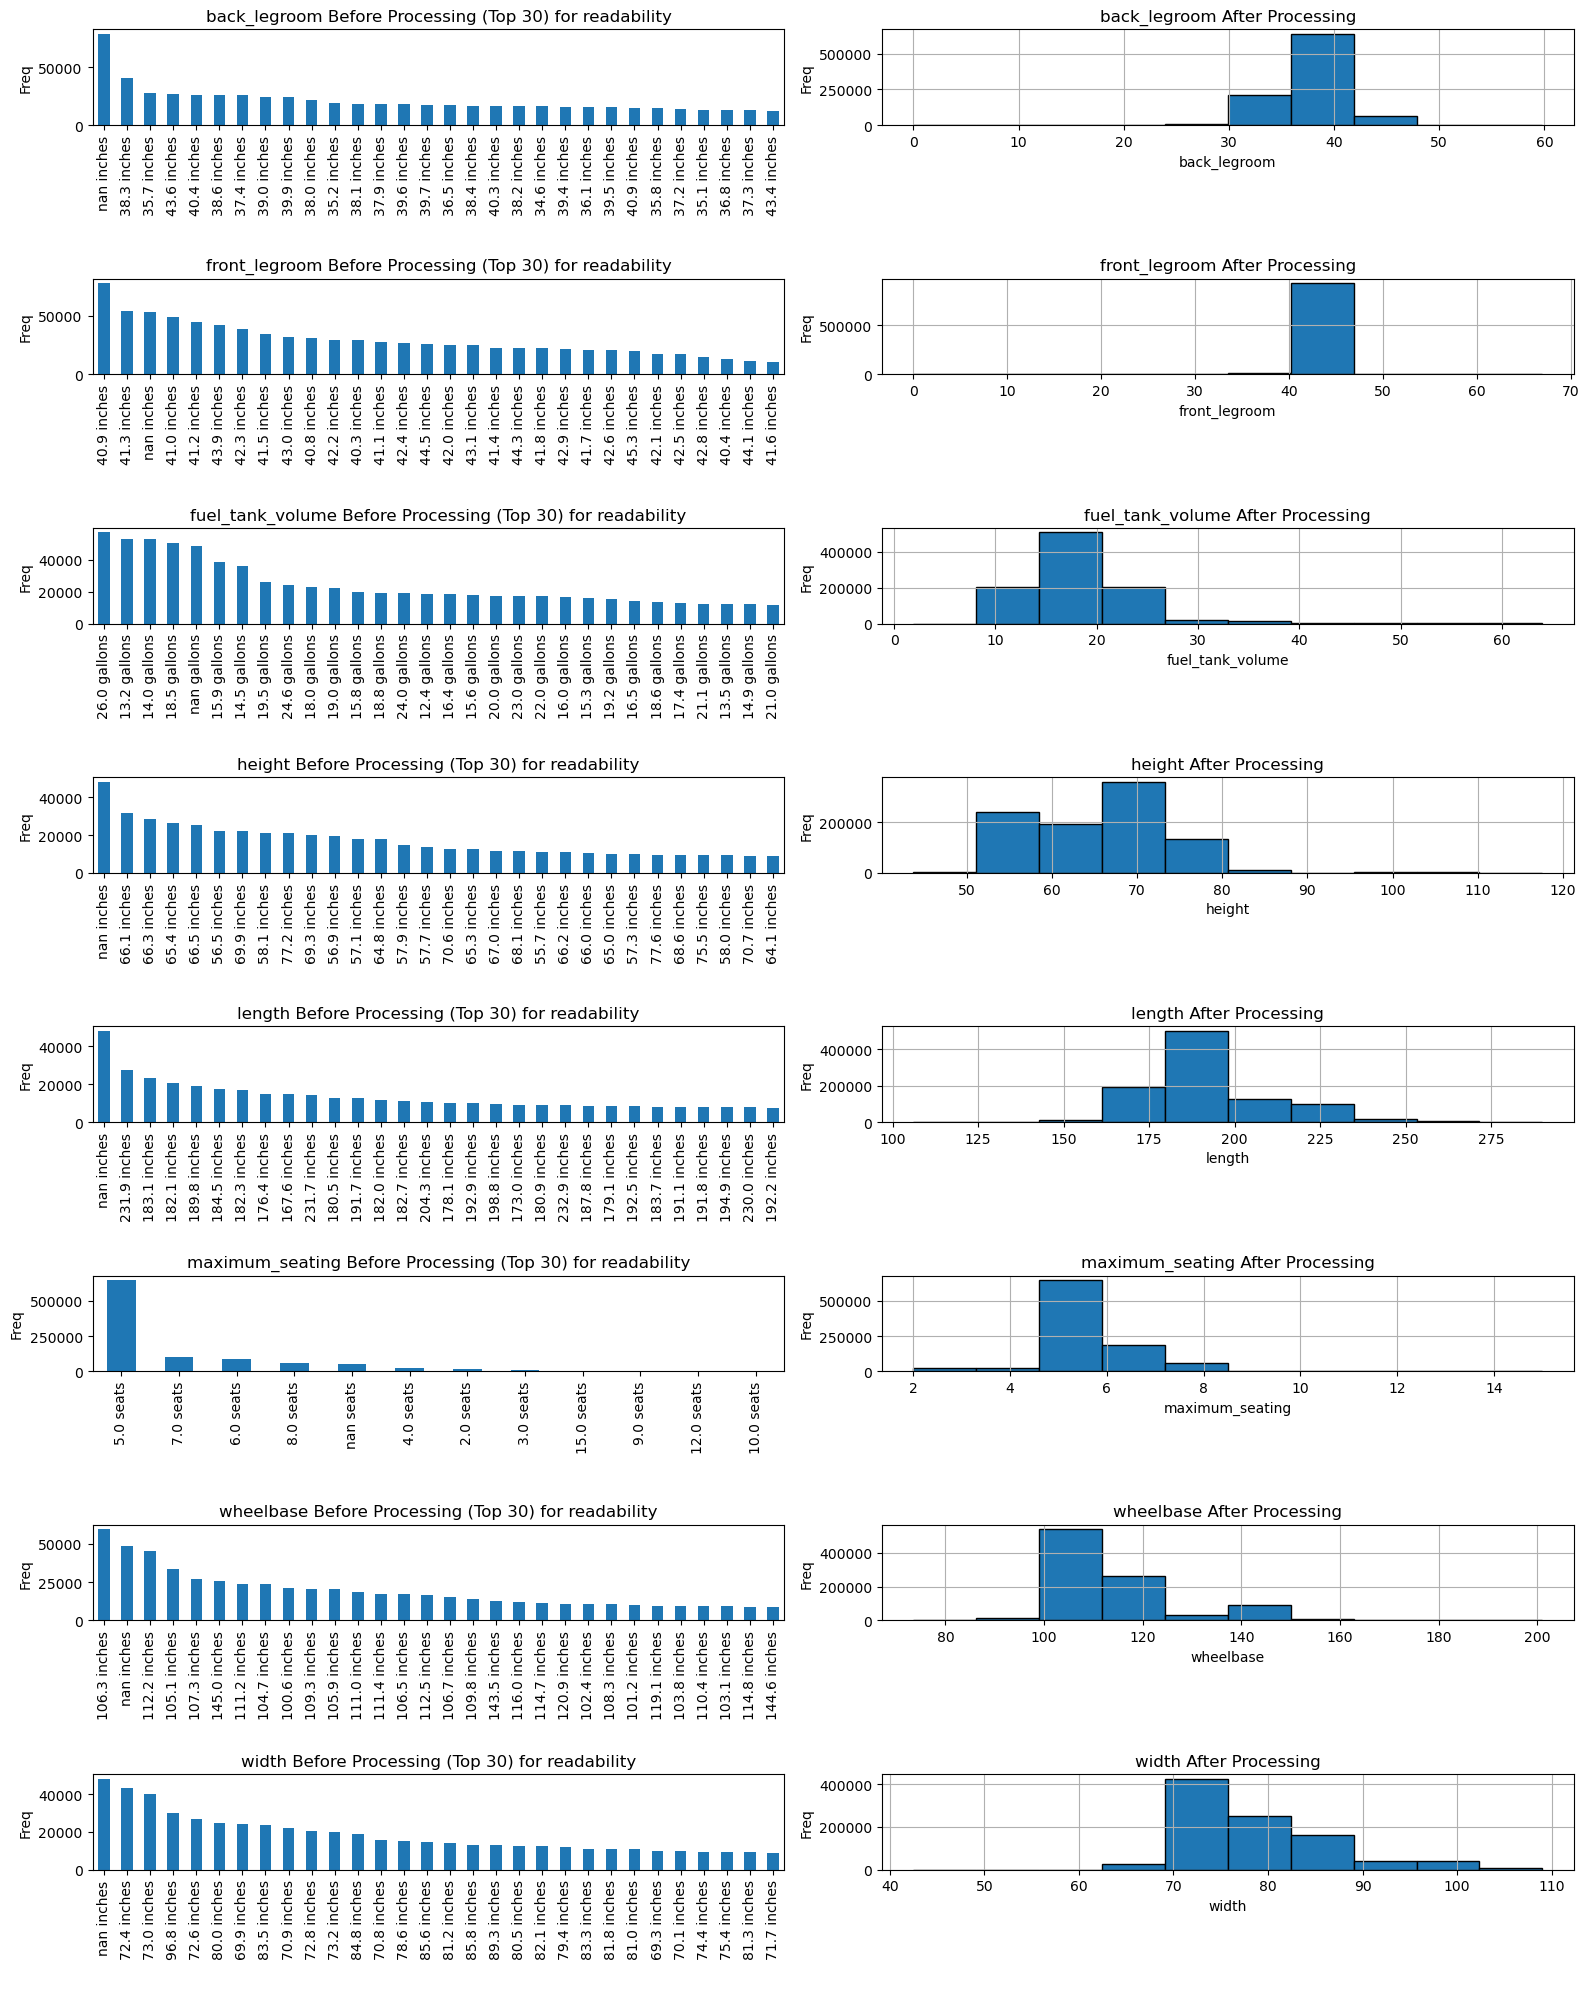

In [5]:
import matplotlib.pyplot as plt

# Simuloidaan alkuperäinen df jotta voidaan vertailla ja muokataan alkuperäiset arvot lisäämällä yksiköt takaisin
original_dataframe = dataframe.copy()

columns_with_units = {
    'back_legroom': 'inches',
    'front_legroom': 'inches',
    'fuel_tank_volume': 'gallons',
    'height': 'inches',
    'length': 'inches',
    'maximum_seating': 'seats',
    'wheelbase': 'inches',
    'width': 'inches'
}

for column, unit in columns_with_units.items():
    original_dataframe[column] = original_dataframe[column].astype(str) + f' {unit}'

columns_to_visualize = [
    'back_legroom', 'front_legroom', 'fuel_tank_volume', 
    'height', 'length', 'maximum_seating', 'wheelbase', 'width'
]

plt.figure(figsize=(16, 20))
for i, column in enumerate(columns_to_visualize, start=1):
    # Ennen preprosessointia
    plt.subplot(len(columns_to_visualize), 2, 2 * i - 1)
    original_dataframe[column].value_counts().head(30).plot(kind='bar')
    plt.title(f'{column} Before Processing (Top 30) for readability')
    plt.xlabel(" ")  # Poistetaan x-akselin otsikko
    plt.ylabel('Freq')
    
    # Jälkeen preprosessoinnin
    plt.subplot(len(columns_to_visualize), 2, 2 * i)
    dataframe[column].hist(bins=10, edgecolor='black')
    plt.title(f'{column} After Processing')
    plt.xlabel(column)
    plt.ylabel('Freq')

plt.tight_layout()
plt.show()



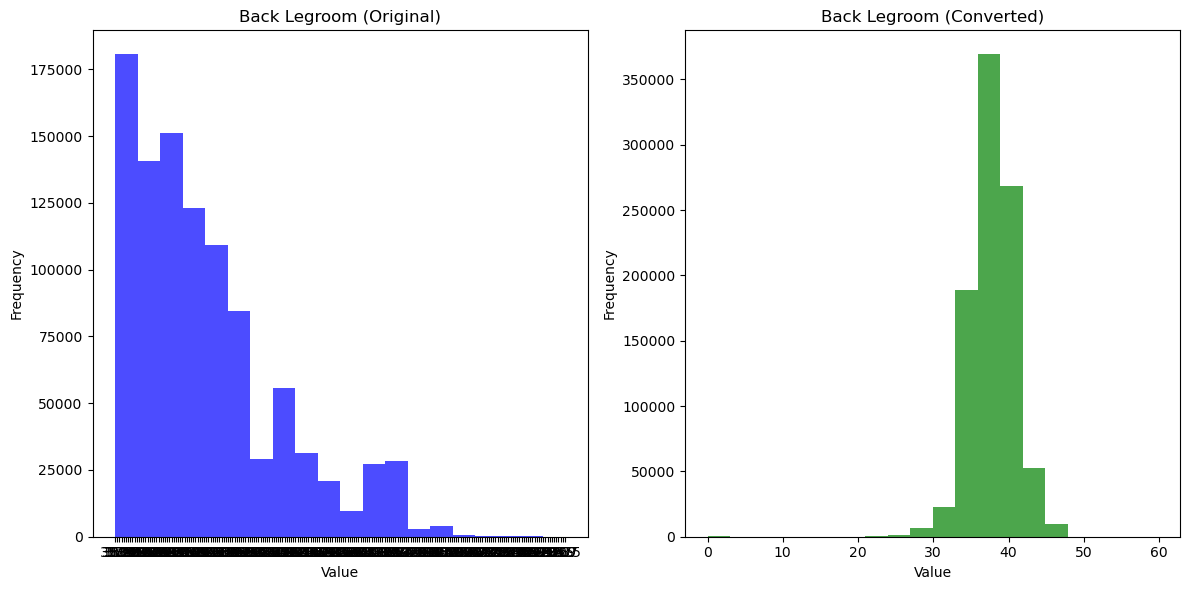

In [6]:
import matplotlib.pyplot as plt

# Histogrammi esimerkki: back_legroom ennen ja jälkeen
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Alkuperäinen jakauma
dataframe['back_legroom_raw'] = dataframe['back_legroom'].astype(str)  # Luo kopio alkuperäisestä
axs[0].hist(dataframe['back_legroom_raw'].dropna(), bins=20, color='blue', alpha=0.7)
axs[0].set_title('Back Legroom (Original)')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

# Muunnettu jakauma
axs[1].hist(dataframe['back_legroom'].dropna(), bins=20, color='green', alpha=0.7)
axs[1].set_title('Back Legroom (Converted)')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


Käsitellään fleet-sarake täyttämällä puuttuvat arvot (NaN) arvolla 'False' ja muuttamalla sarake boolean-tyyppiseksi (True tai False).

Lasketaan kuinka monta True- ja False-arvoa löytyy, ja tulokset näytetään jotta ne voidaan tarkastaa. Sama tehdään myös muille kolumenille alempana.

In [7]:
df_copy = dataframe.copy()

# Fill NaN values with 'False' 
df_copy['fleet'] = df_copy['fleet'].fillna('False') 

# Convert the column to boolean type 
df_copy['fleet'] = df_copy['fleet'].astype(bool) 

# Count the number of True and False values in the 'fleet' column
true_count_fleet = df_copy['fleet'].value_counts().get(True, 0)
false_count_fleet = df_copy['fleet'].value_counts().get(False, 0)
null_count = df_copy['fleet'].isna().sum()
# Create a new DataFrame with the counts
fleet_counts = pd.DataFrame({
    'True': [true_count_fleet],
    'False': [false_count_fleet],
    'Null': [null_count]
})

print(fleet_counts)
print(df_copy['fleet'].dtypes)
# Show the sums of unique values in the 'fleet_3' column
unique_value_counts = df_copy['fleet'].value_counts()

# Display the result
print(unique_value_counts)

     True   False  Null
0  544621  455379     0
bool
fleet
True     544621
False    455379
Name: count, dtype: int64


In [8]:
# Preprosessataan nämä objekti-kolumnit booleaniksi:

# fleet boolenaiksi
dataframe['fleet'] = dataframe['fleet'].fillna('False')
dataframe['fleet'] = dataframe['fleet'].astype(bool)

# frame_damaged boolenaiksi
dataframe['frame_damaged'] = dataframe['frame_damaged'].fillna('False')
dataframe['frame_damaged'] = dataframe['frame_damaged'].astype(bool)

# has_accidents boolenaiksi
dataframe['has_accidents'] = dataframe['has_accidents'].fillna('False')
dataframe['has_accidents'] = dataframe['has_accidents'].astype(bool)

# isCab booleaniksi
dataframe['isCab'] = dataframe['isCab'].fillna('False')
dataframe['isCab'] = dataframe['isCab'].astype(bool)

# salvage booleaniksi
dataframe['salvage'] = dataframe['salvage'].fillna('False') 
dataframe['salvage'] = dataframe['salvage'].astype(bool)

# theft_title booleaniksi
dataframe['theft_title'] = dataframe['theft_title'].fillna('False')
dataframe['theft_title'] = dataframe['theft_title'].astype(bool)


In [9]:
#Tarkistetatan menikö oikein
true_count_fleet = dataframe['fleet'].value_counts().get(True, 0)
false_count_fleet = dataframe['fleet'].value_counts().get(False, 0)

fleet_counts = pd.DataFrame({
    'True': [true_count_fleet],
    'False': [false_count_fleet]
})

print(fleet_counts)
# Verify the change by checking unique values in the column
print(dataframe['fleet'].unique())
dataframe['fleet']


     True   False
0  544621  455379
[ True False]


0          True
1          True
2         False
3          True
4          True
          ...  
999995     True
999996    False
999997     True
999998     True
999999    False
Name: fleet, Length: 1000000, dtype: bool

#### Päivämäärän käsittely

Sarake listed_date muunnetaan päivämäärämuotoon (datetime). Päivämääristä luodaan uusia sarakkeita, jotka sisältävät tietoja:
* Vuodesta (listed_year),
* Kuukaudesta (listed_month),
* Viikonpäivästä (listed_dayofweek).

In [10]:
# Päivämäärän käsittely ja luodaan uusia sarakkeita

# muutetaan date datetimeen
dataframe['listed_date'] = pd.to_datetime(dataframe['listed_date'], errors='coerce')

# lisätietoa vuosista päivistä ja kuukausista
dataframe['listed_year'] = dataframe['listed_date'].dt.year
dataframe['listed_month'] = dataframe['listed_date'].dt.month
dataframe['listed_dayofweek'] = dataframe['listed_date'].dt.dayofweek

#### Power- ja Torque-sarakkeiden jakaminen

Sarakkeet power ja torque, jotka sisältävät useita arvoja (esim. "150 hp @ 6000 rpm"), jaetaan kahteen osaan:
* Hevosvoimat (power_hp ja torque_value) otetaan ensimmäisestä arvosta.
* Kierrosluvut (power_rpm ja torque_rpm) otetaan neljännestä arvosta.

Alkuperäiset sarakkeet power ja torque poistetaan, koska ne on jaettu.

In [11]:
# Jaetaan power -sarake hevosvoimiksi (power_hp) ja kierrosluvuiksi (power_rmp)

dataframe['power_hp'] = dataframe['power'].apply(lambda x: x.split()[0] if isinstance(x, str) else None)
dataframe['power_rpm'] = dataframe['power'].apply(lambda x: x.split()[3] if isinstance(x, str) and len(x.split()) >= 4 else None)

dataframe['power_hp'] = pd.to_numeric(dataframe['power_hp'], errors='coerce')
dataframe['power_rpm'] = pd.to_numeric(dataframe['power_rpm'], errors='coerce')

# Poistetaan alkuperäinen power -sarake
dataframe.drop(columns=['power'], inplace=True)


In [12]:
# Jaetaan torque samalla tavallu kun power
dataframe['torque_value'] = dataframe['torque'].apply(lambda x: x.split()[0] if isinstance(x, str) else None)
dataframe['torque_rpm'] = dataframe['torque'].apply(lambda x: x.split()[3] if isinstance(x, str) and len(x.split()) >= 4 else None)

dataframe['torque_value'] = pd.to_numeric(dataframe['torque_value'], errors='coerce')
dataframe['torque_rpm'] = pd.to_numeric(dataframe['torque_rpm'], errors='coerce')

# Poistetaan alkuperäinen torque -sarake
dataframe.drop(columns=['torque'], inplace=True)



#### Numeristen sarakkeiden siivous

Sarakkeet, kuten front_legroom, fuel_tank_volume, jne., tarkistetaan, sisältävätkö ne virheellisiä arvoja, kuten "--", ja näiden rivien määrä lasketaan.

In [13]:
# Tarkistetaan sisältävätkö rivit "--" arvoja
columns_to_check = ['front_legroom', 'fuel_tank_volume', 'height', 'maximum_seating', 
                    'power_hp', 'power_rpm', 'torque_rpm', 'wheelbase', 'width', 'back_legroom']

for col in columns_to_check:
    count = (dataframe[col] == '--').sum()
    print(f"Column '{col}' has {count} rows with '--'")

Column 'front_legroom' has 0 rows with '--'
Column 'fuel_tank_volume' has 0 rows with '--'
Column 'height' has 0 rows with '--'
Column 'maximum_seating' has 0 rows with '--'
Column 'power_hp' has 0 rows with '--'
Column 'power_rpm' has 0 rows with '--'
Column 'torque_rpm' has 0 rows with '--'
Column 'wheelbase' has 0 rows with '--'
Column 'width' has 0 rows with '--'
Column 'back_legroom' has 0 rows with '--'


### Välitsekkaus sarakkeiden tyyppimuunnoksista.

- Kuvaajista huomataan, että objekti-tyyppisten sarakkeiden määrä alkanut vähentyä.

In [14]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 53 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   back_legroom          920904 non-null   float64       
 1   body_type             995631 non-null   object        
 2   city                  1000000 non-null  object        
 3   city_fuel_economy     836741 non-null   float64       
 4   daysonmarket          1000000 non-null  int64         
 5   dealer_zip            999791 non-null   float64       
 6   engine_displacement   948298 non-null   float64       
 7   exterior_color        984313 non-null   object        
 8   fleet                 1000000 non-null  bool          
 9   frame_damaged         1000000 non-null  bool          
 10  franchise_dealer      1000000 non-null  bool          
 11  franchise_make        803215 non-null   object        
 12  front_legroom         946602 non-null   flo

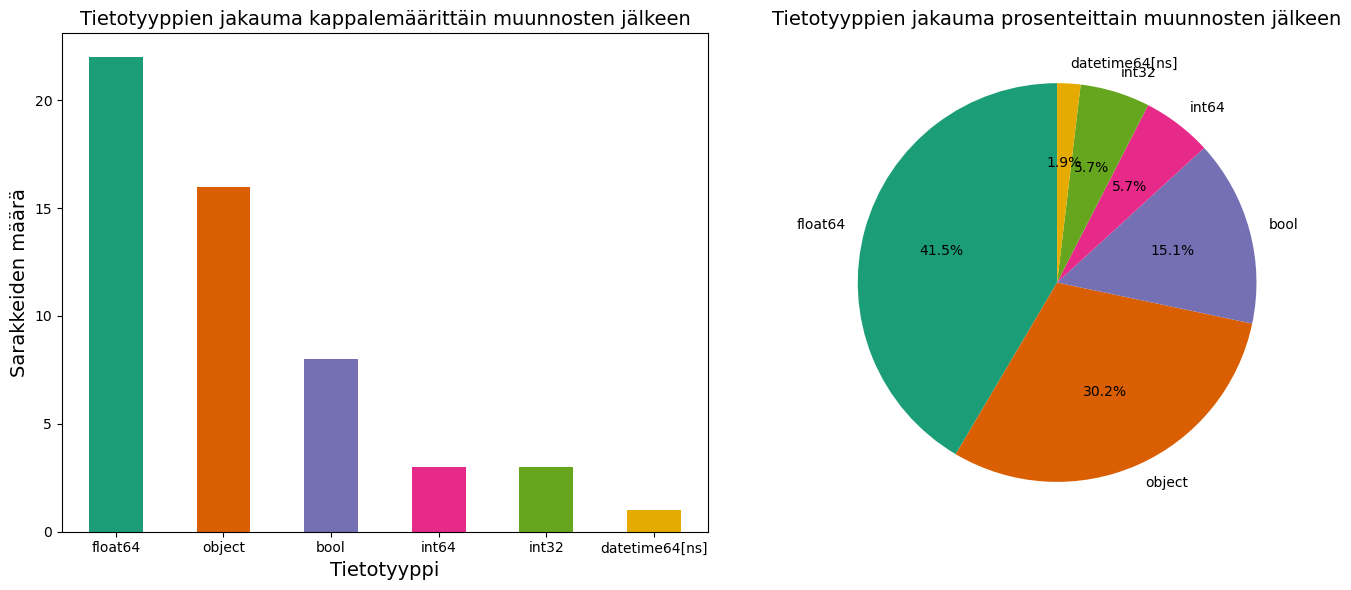

In [15]:
import matplotlib.pyplot as plt

data_types_plot2 = dataframe.dtypes.value_counts()
colors = cm.Dark2.colors

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Barplot
data_types_plot2.plot(
    kind="bar",
    ax=axes[0],
    color=colors
)

axes[0].tick_params(axis="x", rotation=0)
axes[0].set_title("Tietotyyppien jakauma kappalemäärittäin muunnosten jälkeen", fontsize=14)
axes[0].set_xlabel("Tietotyyppi", fontsize=14)
axes[0].set_ylabel("Sarakkeiden määrä", fontsize=14)

# Pie
data_types_plot2.plot(
    kind="pie",
    ax=axes[1],
    autopct="%1.1f%%",
    startangle=90,
    ylabel="",
    colors=colors
)

axes[1].set_title("Tietotyyppien jakauma prosenteittain muunnosten jälkeen", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

### Numeeristen sarakkeiden tilastollinen yhteenveto

In [16]:
print("Statistical Summary of Numerical Columns:")
dataframe = dataframe.query('year >= 1990')
round(dataframe.select_dtypes(exclude = ['object']).describe() , 2)

Statistical Summary of Numerical Columns:


,back_legroom,city_fuel_economy,daysonmarket,dealer_zip,engine_displacement,front_legroom,fuel_tank_volume,height,highway_fuel_economy,horsepower,...,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,power_hp,power_rpm,torque_value,torque_rpm
count,920749.00,836514.00,998306.00,998097.00,947890.00,946314.00,951281.00,951335.00,836514.00,947890.00,...,951338.00,951339.00,998306.00,998306.00,998306.00,998306.00,848534.00,1307.00,836384.00,21390.00
mean,37.87,22.40,77.69,26077.54,2885.08,42.14,18.37,65.81,29.14,243.23,...,114.26,78.22,2017.66,2019.92,7.27,3.49,246.90,633.45,258.28,200.86
min,0.00,7.00,0.00,922.00,700.00,0.00,1.90,43.70,10.00,70.00,...,73.50,42.50,1990.00,2010.00,1.00,0.00,70.00,516.00,68.00,200.00
25%,36.00,18.00,14.00,11207.00,2000.00,41.00,14.50,58.30,25.00,174.00,...,106.20,72.40,2017.00,2020.00,7.00,2.00,174.00,600.00,175.00,200.00
50%,38.10,21.00,35.00,21157.00,2500.00,41.80,17.30,66.10,28.00,240.00,...,110.50,77.20,2019.00,2020.00,8.00,4.00,245.00,650.00,258.00,200.00
75%,39.60,26.00,83.00,44124.00,3500.00,43.00,21.00,69.90,33.00,295.00,...,117.30,82.80,2020.00,2020.00,8.00,5.00,301.00,650.00,295.00,200.00
max,59.80,127.00,3573.00,99518.00,8400.00,67.00,64.00,117.60,127.00,1001.00,...,201.00,109.00,2021.00,2020.00,12.00,6.00,903.00,650.00,935.00,400.00
std,3.03,7.84,109.49,18475.66,1280.00,1.50,5.15,7.33,7.07,87.29,...,13.62,7.46,3.69,0.30,2.14,1.68,88.02,28.36,112.19,8.94


## Kategoriset sarakkeet:

- Katsotaan mitä arvoja jäljelle jääneet kategoriset "object" -tyyppiset sarakkeet pitävät sisällään.

- Nämä pitää esikäsitellä mallin ymmärtämään muotoon, esim. encoding.

- Osassa sarakkeita on liikaa uniikkeja arvoja enkoodauksen kannalta.
    - Katsotaan, voidaanko ryhmitellä arvoja, jotta enkoodauksesta tulisi kannattavampaa
    - Harkitaan, voidaanko sarake poistaa: Onko sarakkeessa oleva tieto tärkeä lopputuloksen kannalta

In [17]:
cat_cols = dataframe.select_dtypes(include=['object']).columns
for col in cat_cols:
    unique_values = dataframe[col].unique()
    print(f"Total unique values: {len(unique_values)}")
    print("Top 10 most common values:")
    print(dataframe[col].value_counts().head(10))  # Show top 10 most common values
    print("\n")


Total unique values: 10
Top 10 most common values:
body_type
SUV / Crossover    508581
Sedan              236548
Pickup Truck       134055
Hatchback           28797
Minivan             25577
Coupe               19791
Van                 19310
Wagon               14079
Convertible          7336
Name: count, dtype: int64


Total unique values: 3212
Top 10 most common values:
city
Columbus          10471
Raleigh            9241
Chicago            8832
Charlotte          8088
Richmond           7636
Rochester          5313
Virginia Beach     5255
Pittsburgh         5226
Grand Rapids       5021
Knoxville          4988
Name: count, dtype: int64


Total unique values: 15007
Top 10 most common values:
exterior_color
Black                     58651
White                     38419
Summit White              30202
Gray                      27178
Silver                    25104
Blue                      19718
Oxford White              17239
Red                       14337
Bright White Clearcoat    

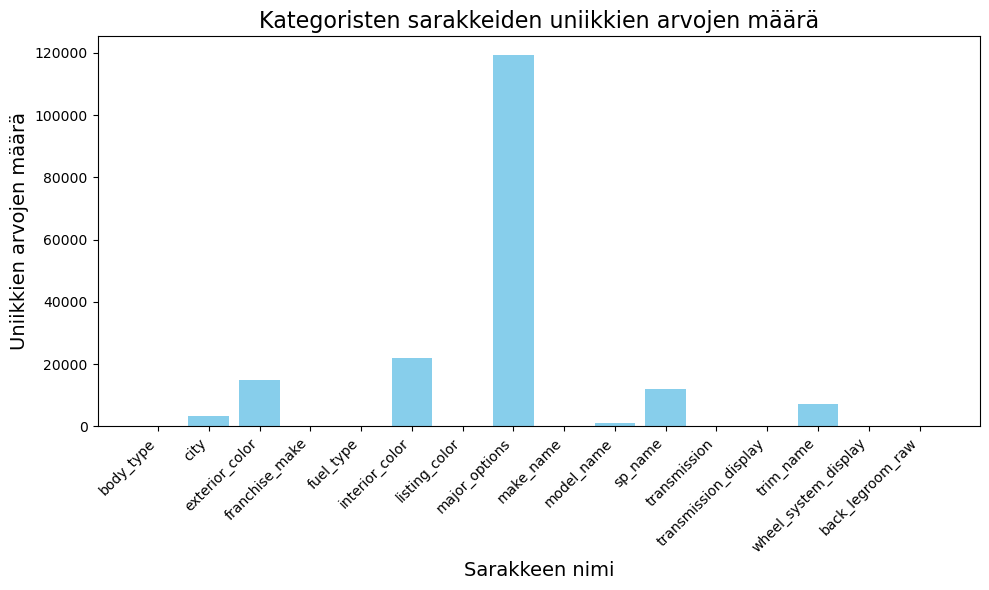

In [18]:
import matplotlib.pyplot as plt

cat_cols = dataframe.select_dtypes(include=['object']).columns

unique_counts = {col: dataframe[col].nunique() for col in cat_cols}


plt.figure(figsize=(10,6))
plt.bar(unique_counts.keys(), unique_counts.values(), color="skyblue")

plt.title("Kategoristen sarakkeiden uniikkien arvojen määrä", fontsize=16)
plt.xlabel("Sarakkeen nimi", fontsize=14)
plt.ylabel("Uniikkien arvojen määrä", fontsize=14)
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()


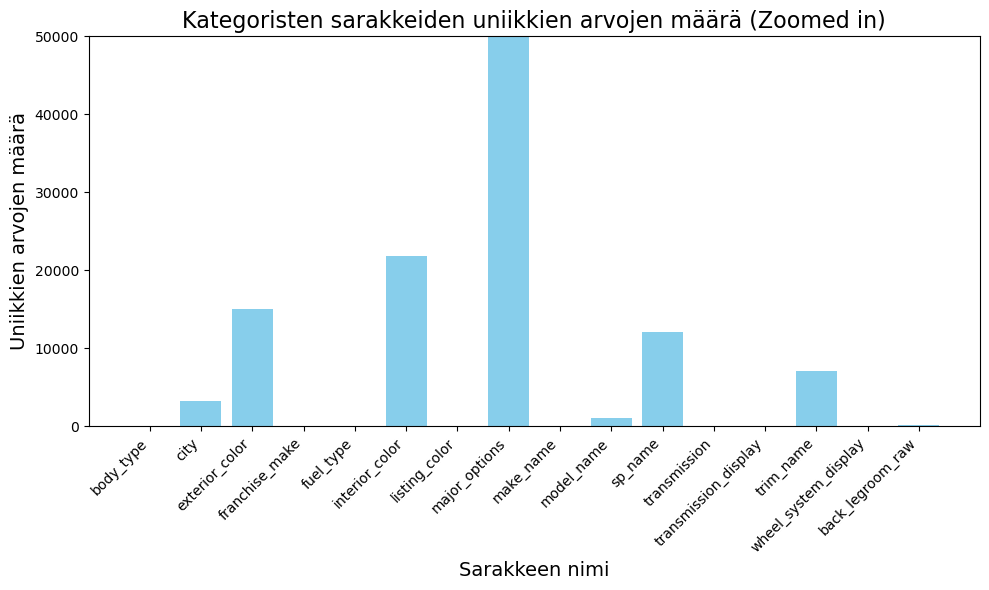

In [19]:
# Zoomattu pylväskaavio
plt.figure(figsize=(10, 6))

plt.bar(unique_counts.keys(), unique_counts.values(), color="skyblue")

plt.title("Kategoristen sarakkeiden uniikkien arvojen määrä (Zoomed in)", fontsize=16)
plt.xlabel("Sarakkeen nimi", fontsize=14)
plt.ylabel("Uniikkien arvojen määrä", fontsize=14)
plt.xticks(rotation=45, ha="right")

# Zoomattu y-akselin mukaan
plt.ylim(0, 50000)

plt.tight_layout()
plt.show()


### Sisältävätkö kategoriset sarakkeet NaN-arvoja:

In [20]:
cat_cols = dataframe.select_dtypes(include=['object']).columns

# Calculate null counts for each categorical column
null_counts = dataframe[cat_cols].isnull().sum().sort_values(ascending=False)
print(null_counts)

franchise_make          195318
interior_color          119650
major_options            66700
wheel_system_display     44349
trim_name                35403
fuel_type                23617
transmission             16484
transmission_display     16484
exterior_color           15649
body_type                 4232
city                         0
listing_color                0
make_name                    0
model_name                   0
sp_name                      0
back_legroom_raw             0
dtype: int64


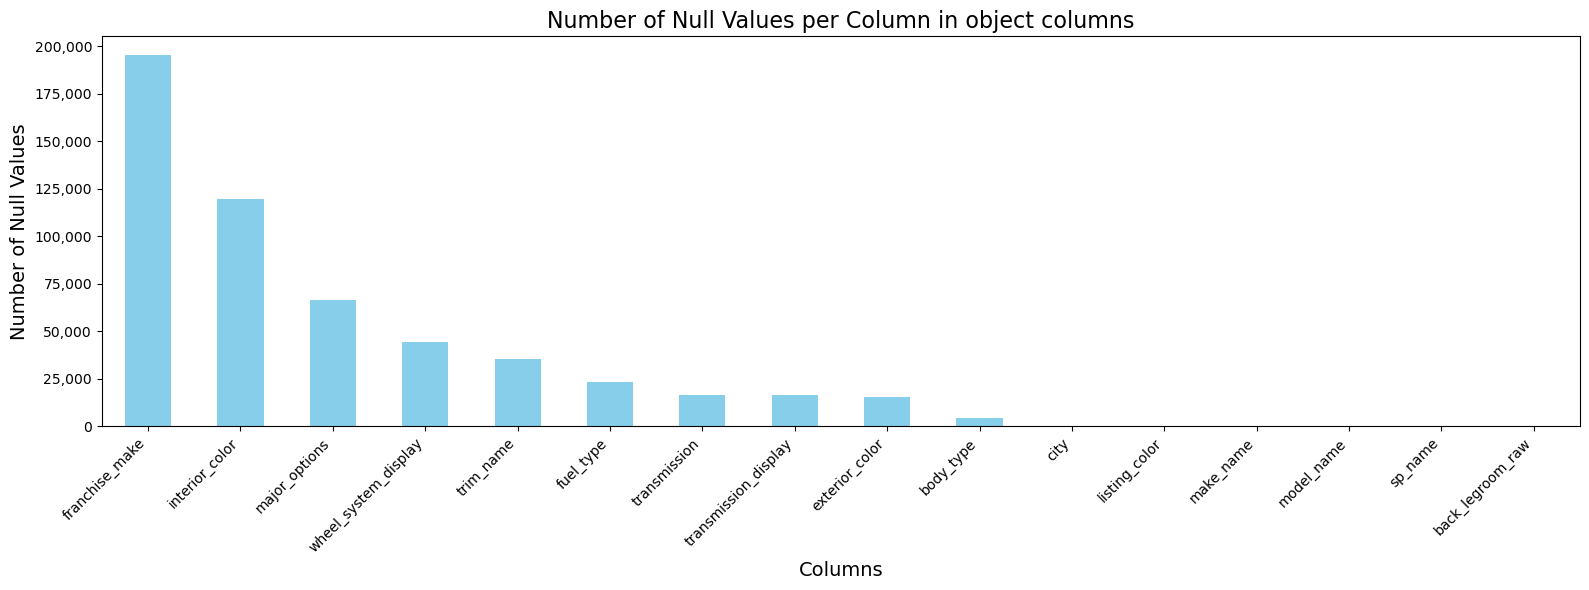

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
null_counts.plot.bar(color='skyblue')
plt.title('Number of Null Values per Column in object columns', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Number of Null Values', fontsize=14)
plt.xticks(rotation=45, ha='right')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

## NaN-arvojen kasittely

- Katsotaan sarakkeittain NaN-arvojen määriä suuruusjärjestyksessä, sis sekä numeeriset että kategoriset sarakkeet
- Yhdistetään 'make_name' ja 'franchise_make' -sarakkeet, sillä suuri osa arvoista yhtenäisiä
- Poistetaan sarakkeet, jotka pitävät sisällään suurimman määrän NaN-arvoja
- Lopuksi poistetaan kaikki rivit, jotka pitävät sisällään NaN-arvoja

In [22]:
nan_counts = pd.DataFrame({'Column': dataframe.columns, 'NaN_Count': dataframe.isna().sum()}).reset_index(drop=True)
nan_counts_sorted = nan_counts.sort_values(by='NaN_Count', ascending=False).reset_index(drop=True)

print(f"Rivien määrä: {len(dataframe)}")
print(f"Sarakkeiden määrä: {len(dataframe.columns)}")
print("tyhjien arvojen määrä per sarake")
print(nan_counts_sorted)

Rivien määrä: 998306
Sarakkeiden määrä: 53
tyhjien arvojen määrä per sarake
                  Column  NaN_Count
0              power_rpm     996999
1             torque_rpm     976916
2            owner_count     493681
3         franchise_make     195318
4           torque_value     161922
5      city_fuel_economy     161792
6   highway_fuel_economy     161792
7               power_hp     149772
8         interior_color     119650
9           back_legroom      77557
10         major_options      66700
11         front_legroom      51992
12               mileage      50474
13   engine_displacement      50416
14            horsepower      50416
15      fuel_tank_volume      47025
16       maximum_seating      46991
17                height      46971
18             wheelbase      46968
19                length      46968
20                 width      46967
21  wheel_system_display      44349
22             trim_name      35403
23             fuel_type      23617
24          transmission

### Katsotaan paljonko power_rpm -sarake pitää sisällään ei-NaN arvoja
- Tuloksena saadaan, että sarake pitää sisällään niin vähän oikeita arvoja, että sarake tullaan poistamaan pian

In [23]:
# Filter rows with non-NaN values in 'power_rpm'
filtered_df = dataframe[dataframe['power_rpm'].notna()]

len(filtered_df)

1307

### franchise_make ja make_name

- Huomataan, että franchise_make ja make_name käytännössä tarkoittavat samaa asiaa
- Korvataan franchise_make -sarakkeen NaN-arvot make_name -sarakkeen arvoilla

In [24]:
# Replace NaN in franchise_make with values from make_name
dataframe['franchise_make'] = dataframe['franchise_make'].fillna(dataframe['make_name'])

# Find rows where franchise_make is different from make_name
mismatch_count = (dataframe['franchise_make'] != dataframe['make_name']).sum()

print(f"Number of rows with different franchise_make and make_name: {mismatch_count}")

Number of rows with different franchise_make and make_name: 142670


In [25]:
#tarkistetaan nyt franchise make

nan_counts = pd.DataFrame({'Column': dataframe.columns, 'NaN_Count': dataframe.isna().sum()}).reset_index(drop=True)
nan_counts_sorted = nan_counts.sort_values(by='NaN_Count', ascending=False).reset_index(drop=True)

print(f"Rivien määrä: {len(dataframe)}")
print(f"Sarakkeiden määrä: {len(dataframe.columns)}")
print("tyhjien arvojen määrä per sarake")
print(nan_counts_sorted)

Rivien määrä: 998306
Sarakkeiden määrä: 53
tyhjien arvojen määrä per sarake
                  Column  NaN_Count
0              power_rpm     996999
1             torque_rpm     976916
2            owner_count     493681
3           torque_value     161922
4   highway_fuel_economy     161792
5      city_fuel_economy     161792
6               power_hp     149772
7         interior_color     119650
8           back_legroom      77557
9          major_options      66700
10         front_legroom      51992
11               mileage      50474
12            horsepower      50416
13   engine_displacement      50416
14      fuel_tank_volume      47025
15       maximum_seating      46991
16                height      46971
17             wheelbase      46968
18                length      46968
19                 width      46967
20  wheel_system_display      44349
21             trim_name      35403
22             fuel_type      23617
23  transmission_display      16484
24          transmission

### Poistetaan kolme eniten tyhjiä arvoja sisältävää saraketta

Poistettavat sarakkeet ovat:
1. power_rpm, 
2. torque_rpm,
3. owner_count


In [26]:
dataframe.drop(columns=['power_rpm', 'torque_rpm', 'owner_count'], inplace=True)

nan_counts = pd.DataFrame({'Column': dataframe.columns, 'NaN_Count': dataframe.isna().sum()}).reset_index(drop=True)
nan_counts_sorted = nan_counts.sort_values(by='NaN_Count', ascending=False).reset_index(drop=True)

print(f"Rivien määrä: {len(dataframe)}")
print(f"Sarakkeiden määrä: {len(dataframe.columns)}")
print("tyhjien arvojen määrä per sarake")
print(nan_counts_sorted.head(10))

Rivien määrä: 998306
Sarakkeiden määrä: 50
tyhjien arvojen määrä per sarake
                 Column  NaN_Count
0          torque_value     161922
1  highway_fuel_economy     161792
2     city_fuel_economy     161792
3              power_hp     149772
4        interior_color     119650
5          back_legroom      77557
6         major_options      66700
7         front_legroom      51992
8               mileage      50474
9   engine_displacement      50416


### Testataan paljonko jää rivejä jos poistetaan kaikki rivit, jotka sisältää NaN-arvoja

In [27]:
cleaned_df = dataframe.dropna()

print(cleaned_df.shape)

(572253, 50)


### Poistetaan seuraavat 3 eniten tyhjiä arvoja sisältävää saraketta

Poistettavat sarakkeet ovat:
1. torque_value, 
2. highway_fuel_economy,
3. city_fuel_economy

Poistetaan myös "power_hp" -niminen sarake, sillä siinä samat arvot kuin "horsepower" -sarakkeessa.

In [28]:
dataframe.drop(columns=['torque_value', 'highway_fuel_economy', 'city_fuel_economy', 'power_hp'], inplace=True)

nan_counts = pd.DataFrame({'Column': dataframe.columns, 'NaN_Count': dataframe.isna().sum()}).reset_index(drop=True)
nan_counts_sorted = nan_counts.sort_values(by='NaN_Count', ascending=False).reset_index(drop=True)

print(f"Rivien määrä: {len(dataframe)}")
print(f"Sarakkeiden määrä: {len(dataframe.columns)}")
print("tyhjien arvojen määrä per sarake")
print(nan_counts_sorted.head(10))

Rivien määrä: 998306
Sarakkeiden määrä: 46
tyhjien arvojen määrä per sarake
                Column  NaN_Count
0       interior_color     119650
1         back_legroom      77557
2        major_options      66700
3        front_legroom      51992
4              mileage      50474
5           horsepower      50416
6  engine_displacement      50416
7     fuel_tank_volume      47025
8      maximum_seating      46991
9               height      46971


### Uusi testaus paljonko jää rivejä jos poistetaan kaikki rivit, jotka sisältää NaN-arvoja

- Todetaan, että rivejä jää nyt riittävä määrä, eikä haluta enää poistaa sarakkeita

In [29]:
#sp_name:ssa myyjän lisäämiä asioita esim. GT, Sport, kaupunki missä myynnissä
#trim_name trimmattu nimi
#transmission_display tarkemmat arvot vaihteille, monta erilaista tekstiä, jätetään transmission -sarake kuvaamaan automati, manual, ctv ja dual clutchia.
dataframe.drop(columns=['exterior_color', 'interior_color', 'sp_name', 'trim_name', 'transmission_display', 'back_legroom_raw'], inplace=True)


cleaned_df2 = dataframe.dropna()

print(cleaned_df2.shape)
print(cleaned_df2.columns)
pd.set_option('display.max_columns', None)

#len(cleaned_df2['sp_name'].unique())
cleaned_df2.head(5)


(796451, 40)
Index(['back_legroom', 'body_type', 'city', 'daysonmarket', 'dealer_zip',
       'engine_displacement', 'fleet', 'frame_damaged', 'franchise_dealer',
       'franchise_make', 'front_legroom', 'fuel_tank_volume', 'fuel_type',
       'has_accidents', 'height', 'horsepower', 'isCab', 'is_new', 'length',
       'listed_date', 'listing_color', 'major_options', 'make_name',
       'maximum_seating', 'mileage', 'model_name', 'price', 'salvage',
       'savings_amount', 'seller_rating', 'sp_id', 'theft_title',
       'transmission', 'wheel_system_display', 'wheelbase', 'width', 'year',
       'listed_year', 'listed_month', 'listed_dayofweek'],
      dtype='object')


,back_legroom,body_type,city,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,horsepower,isCab,is_new,length,listed_date,listing_color,major_options,make_name,maximum_seating,mileage,model_name,price,salvage,savings_amount,seller_rating,sp_id,theft_title,transmission,wheel_system_display,wheelbase,width,year,listed_year,listed_month,listed_dayofweek
0,35.1,SUV / Crossover,Bayamon,522,960.0,1300.0,True,True,True,Jeep,41.2,12.7,Gasoline,True,66.5,177.0,True,True,166.6,2019-04-06,YELLOW,['Quick Order Package'],Jeep,5.0,7.0,Renegade,23141.0,True,0,2.8,370599.0,True,A,Front-Wheel Drive,101.2,79.6,2019,2019,4,5
1,38.1,SUV / Crossover,San Juan,207,922.0,2000.0,True,True,True,Land Rover,39.1,17.7,Gasoline,True,68.0,246.0,True,True,181.0,2020-02-15,BLACK,['Adaptive Cruise Control'],Land Rover,7.0,8.0,Discovery Sport,46500.0,True,0,3.0,389227.0,True,A,All-Wheel Drive,107.9,85.6,2020,2020,2,5
4,38.1,SUV / Crossover,San Juan,137,922.0,2000.0,True,True,True,Land Rover,39.1,17.7,Gasoline,True,68.0,246.0,True,True,181.0,2020-04-25,BLACK,['Adaptive Cruise Control'],Land Rover,7.0,7.0,Discovery Sport,48880.0,True,0,3.0,389227.0,True,A,All-Wheel Drive,107.9,85.6,2020,2020,4,5
5,37.1,SUV / Crossover,San Juan,242,922.0,2000.0,False,False,True,Land Rover,40.2,16.6,Gasoline,False,66.3,247.0,False,True,188.9,2020-01-11,UNKNOWN,"['Leather Seats', 'Sunroof/Moonroof', 'Navigat...",Land Rover,5.0,12.0,Range Rover Velar,66903.0,False,0,3.0,389227.0,False,A,All-Wheel Drive,113.1,84.4,2020,2020,1,5
6,35.1,Sedan,Bayamon,447,960.0,2500.0,True,True,True,Jeep,42.3,13.2,Gasoline,True,56.9,186.0,True,True,183.5,2019-06-20,SILVER,"['Alloy Wheels', 'Bluetooth', 'Backup Camera']",Mazda,5.0,14.0,MAZDA3,23695.0,True,0,2.8,370599.0,True,A,Front-Wheel Drive,107.3,70.7,2019,2019,6,3


## Datan One-Hot enkoodaus

### One-Hot enkoodaus "fuel_type"-sarake

In [30]:
cleaned_df2['fuel_type'].unique()

cleaned_df2 = pd.get_dummies(cleaned_df2, columns=['fuel_type'], prefix='fuel_type')
cleaned_df2.head(2)

,back_legroom,body_type,city,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,has_accidents,height,horsepower,isCab,is_new,length,listed_date,listing_color,major_options,make_name,maximum_seating,mileage,model_name,price,salvage,savings_amount,seller_rating,sp_id,theft_title,transmission,wheel_system_display,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,fuel_type_Biodiesel,fuel_type_Compressed Natural Gas,fuel_type_Diesel,fuel_type_Flex Fuel Vehicle,fuel_type_Gasoline,fuel_type_Hybrid
0,35.1,SUV / Crossover,Bayamon,522,960.0,1300.0,True,True,True,Jeep,41.2,12.7,True,66.5,177.0,True,True,166.6,2019-04-06,YELLOW,['Quick Order Package'],Jeep,5.0,7.0,Renegade,23141.0,True,0,2.8,370599.0,True,A,Front-Wheel Drive,101.2,79.6,2019,2019,4,5,False,False,False,False,True,False
1,38.1,SUV / Crossover,San Juan,207,922.0,2000.0,True,True,True,Land Rover,39.1,17.7,True,68.0,246.0,True,True,181.0,2020-02-15,BLACK,['Adaptive Cruise Control'],Land Rover,7.0,8.0,Discovery Sport,46500.0,True,0,3.0,389227.0,True,A,All-Wheel Drive,107.9,85.6,2020,2020,2,5,False,False,False,False,True,False


### One-Hot enkoodaus "wheel_system_display"-sarake

In [31]:
cleaned_df2['wheel_system_display'].unique()

cleaned_df2 = pd.get_dummies(cleaned_df2, columns=['wheel_system_display'], prefix='wheel')
cleaned_df2.head(2)

,back_legroom,body_type,city,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,has_accidents,height,horsepower,isCab,is_new,length,listed_date,listing_color,major_options,make_name,maximum_seating,mileage,model_name,price,salvage,savings_amount,seller_rating,sp_id,theft_title,transmission,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,fuel_type_Biodiesel,fuel_type_Compressed Natural Gas,fuel_type_Diesel,fuel_type_Flex Fuel Vehicle,fuel_type_Gasoline,fuel_type_Hybrid,wheel_4X2,wheel_All-Wheel Drive,wheel_Four-Wheel Drive,wheel_Front-Wheel Drive,wheel_Rear-Wheel Drive
0,35.1,SUV / Crossover,Bayamon,522,960.0,1300.0,True,True,True,Jeep,41.2,12.7,True,66.5,177.0,True,True,166.6,2019-04-06,YELLOW,['Quick Order Package'],Jeep,5.0,7.0,Renegade,23141.0,True,0,2.8,370599.0,True,A,101.2,79.6,2019,2019,4,5,False,False,False,False,True,False,False,False,False,True,False
1,38.1,SUV / Crossover,San Juan,207,922.0,2000.0,True,True,True,Land Rover,39.1,17.7,True,68.0,246.0,True,True,181.0,2020-02-15,BLACK,['Adaptive Cruise Control'],Land Rover,7.0,8.0,Discovery Sport,46500.0,True,0,3.0,389227.0,True,A,107.9,85.6,2020,2020,2,5,False,False,False,False,True,False,False,True,False,False,False


### One-Hot enkoodaus "transmission"-sarake

In [32]:
cleaned_df2['transmission'].unique()

cleaned_df2 = pd.get_dummies(cleaned_df2, columns=['transmission'], prefix='transmission')
cleaned_df2.head(2)

,back_legroom,body_type,city,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,has_accidents,height,horsepower,isCab,is_new,length,listed_date,listing_color,major_options,make_name,maximum_seating,mileage,model_name,price,salvage,savings_amount,seller_rating,sp_id,theft_title,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,fuel_type_Biodiesel,fuel_type_Compressed Natural Gas,fuel_type_Diesel,fuel_type_Flex Fuel Vehicle,fuel_type_Gasoline,fuel_type_Hybrid,wheel_4X2,wheel_All-Wheel Drive,wheel_Four-Wheel Drive,wheel_Front-Wheel Drive,wheel_Rear-Wheel Drive,transmission_A,transmission_CVT,transmission_Dual Clutch,transmission_M
0,35.1,SUV / Crossover,Bayamon,522,960.0,1300.0,True,True,True,Jeep,41.2,12.7,True,66.5,177.0,True,True,166.6,2019-04-06,YELLOW,['Quick Order Package'],Jeep,5.0,7.0,Renegade,23141.0,True,0,2.8,370599.0,True,101.2,79.6,2019,2019,4,5,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False
1,38.1,SUV / Crossover,San Juan,207,922.0,2000.0,True,True,True,Land Rover,39.1,17.7,True,68.0,246.0,True,True,181.0,2020-02-15,BLACK,['Adaptive Cruise Control'],Land Rover,7.0,8.0,Discovery Sport,46500.0,True,0,3.0,389227.0,True,107.9,85.6,2020,2020,2,5,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False


### One-Hot enkoodaus "body_type"-sarake

In [33]:
cleaned_df2['body_type'].unique()

cleaned_df2 = pd.get_dummies(cleaned_df2, columns=['body_type'], prefix='body_type')
cleaned_df2.head(2)

,back_legroom,city,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,has_accidents,height,horsepower,isCab,is_new,length,listed_date,listing_color,major_options,make_name,maximum_seating,mileage,model_name,price,salvage,savings_amount,seller_rating,sp_id,theft_title,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,fuel_type_Biodiesel,fuel_type_Compressed Natural Gas,fuel_type_Diesel,fuel_type_Flex Fuel Vehicle,fuel_type_Gasoline,fuel_type_Hybrid,wheel_4X2,wheel_All-Wheel Drive,wheel_Four-Wheel Drive,wheel_Front-Wheel Drive,wheel_Rear-Wheel Drive,transmission_A,transmission_CVT,transmission_Dual Clutch,transmission_M,body_type_Convertible,body_type_Coupe,body_type_Hatchback,body_type_Minivan,body_type_Pickup Truck,body_type_SUV / Crossover,body_type_Sedan,body_type_Van,body_type_Wagon
0,35.1,Bayamon,522,960.0,1300.0,True,True,True,Jeep,41.2,12.7,True,66.5,177.0,True,True,166.6,2019-04-06,YELLOW,['Quick Order Package'],Jeep,5.0,7.0,Renegade,23141.0,True,0,2.8,370599.0,True,101.2,79.6,2019,2019,4,5,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False
1,38.1,San Juan,207,922.0,2000.0,True,True,True,Land Rover,39.1,17.7,True,68.0,246.0,True,True,181.0,2020-02-15,BLACK,['Adaptive Cruise Control'],Land Rover,7.0,8.0,Discovery Sport,46500.0,True,0,3.0,389227.0,True,107.9,85.6,2020,2020,2,5,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False


### One-Hot enkoodaus "listing_color"-sarake

In [34]:
cleaned_df2['listing_color'].unique()

# Define the color mapping for the listing_color column
color_mapping = {
    'BLACK': 'black, unknown',
    'UNKNOWN': 'black, unknown',
    'YELLOW': 'yellow, orange, gold',
    'ORANGE': 'yellow, orange, gold',
    'GOLD': 'yellow, orange, gold',
    'WHITE': 'white, gray, silver',
    'GRAY': 'white, gray, silver',
    'SILVER': 'white, gray, silver',
    'RED': 'red, blue, green, brown',
    'BLUE': 'red, blue, green, brown',
    'GREEN': 'red, blue, green, brown',
    'BROWN': 'red, blue, green, brown',
    'PURPLE': 'purple, pink, teal',
    'PINK': 'purple, pink, teal',
    'TEAL': 'purple, pink, teal'
}

# Create the new column based on the color mapping
cleaned_df2['combined_listing_color'] = cleaned_df2['listing_color'].map(color_mapping)

# Check the result
print(cleaned_df2[['listing_color', 'combined_listing_color']].head())

cleaned_df2 = pd.get_dummies(cleaned_df2, columns=['combined_listing_color'], prefix='listing_color')
cleaned_df2.head(2)

  listing_color combined_listing_color
0        YELLOW   yellow, orange, gold
1         BLACK         black, unknown
4         BLACK         black, unknown
5       UNKNOWN         black, unknown
6        SILVER    white, gray, silver


,back_legroom,city,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,has_accidents,height,horsepower,isCab,is_new,length,listed_date,listing_color,major_options,make_name,maximum_seating,mileage,model_name,price,salvage,savings_amount,seller_rating,sp_id,theft_title,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,fuel_type_Biodiesel,fuel_type_Compressed Natural Gas,fuel_type_Diesel,fuel_type_Flex Fuel Vehicle,fuel_type_Gasoline,fuel_type_Hybrid,wheel_4X2,wheel_All-Wheel Drive,wheel_Four-Wheel Drive,wheel_Front-Wheel Drive,wheel_Rear-Wheel Drive,transmission_A,transmission_CVT,transmission_Dual Clutch,transmission_M,body_type_Convertible,body_type_Coupe,body_type_Hatchback,body_type_Minivan,body_type_Pickup Truck,body_type_SUV / Crossover,body_type_Sedan,body_type_Van,body_type_Wagon,"listing_color_black, unknown","listing_color_purple, pink, teal","listing_color_red, blue, green, brown","listing_color_white, gray, silver","listing_color_yellow, orange, gold"
0,35.1,Bayamon,522,960.0,1300.0,True,True,True,Jeep,41.2,12.7,True,66.5,177.0,True,True,166.6,2019-04-06,YELLOW,['Quick Order Package'],Jeep,5.0,7.0,Renegade,23141.0,True,0,2.8,370599.0,True,101.2,79.6,2019,2019,4,5,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True
1,38.1,San Juan,207,922.0,2000.0,True,True,True,Land Rover,39.1,17.7,True,68.0,246.0,True,True,181.0,2020-02-15,BLACK,['Adaptive Cruise Control'],Land Rover,7.0,8.0,Discovery Sport,46500.0,True,0,3.0,389227.0,True,107.9,85.6,2020,2020,2,5,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False


### One-Hot enkoodaus "major_options"-sarake

In [35]:
# Ominaisuuksien yleisyys datassa
major_options_counts = cleaned_df2["major_options"].str.strip("[]").str.replace("'", "").str.split(", ").explode().value_counts()
print(major_options_counts)

major_options
Backup Camera                        626504
Bluetooth                            547604
Alloy Wheels                         543412
Heated Seats                         366022
Navigation System                    301217
                                      ...  
Carbon Ceramic Brakes                     3
Levant Package                            2
Grand Tour Package                        2
Z85 Package                               2
Appearance and Protection Package         1
Name: count, Length: 143, dtype: int64


- 143 kpl eri ominaisuuksia, kaikkia ei voi eikä kannata ottaa mukaan, sillä muuten tulee liikaa sarakkeita, eikä loppupäässä ominaisuudet ole tarpeeksi yleisiä. 

- Testataan kuinka paljon valitut ominaisuudet kattavat

In [36]:
covers_from_cars = major_options_counts.cumsum() / major_options_counts.sum()

optimal_features = (covers_from_cars <= 0.80).sum()
print(f"Jos valitaan {optimal_features} kpl ominaisuuksia, se kattaisi 80 % datasta.")

Jos valitaan 12 kpl ominaisuuksia, se kattaisi 80 % datasta.


- 20 isointa ominaisuutta ovat:

In [37]:
print("Top 20 isoimmat ominaisuudet:\n")
print(major_options_counts.head(20))


Top 20 isoimmat ominaisuudet:

major_options
Backup Camera                 626504
Bluetooth                     547604
Alloy Wheels                  543412
Heated Seats                  366022
Navigation System             301217
Sunroof/Moonroof              298929
Remote Start                  270836
CarPlay                       234517
Leather Seats                 231104
Blind Spot Monitoring         220052
Android Auto                  207527
Parking Sensors               144018
Adaptive Cruise Control       137637
Third Row Seating              96607
Quick Order Package            71223
Steel Wheels                   59836
Convenience Package            55390
Premium Package                45398
Tow Package                    30856
Multi Zone Climate Control     28798
Name: count, dtype: int64


- Huomataan, että 13. ja 14. välissä on suurempi ero, joten otetaan mukaan 13 yleisintä ominaisuutta.

In [38]:
import ast

# Varmistetaan, että kaikki arvot ovat listoja
cleaned_df2['major_options'] = cleaned_df2['major_options'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

print(cleaned_df2["major_options"].head(10))

0                                 [Quick Order Package]
1                             [Adaptive Cruise Control]
4                             [Adaptive Cruise Control]
5     [Leather Seats, Sunroof/Moonroof, Navigation S...
6              [Alloy Wheels, Bluetooth, Backup Camera]
7                             [Adaptive Cruise Control]
8     [Navigation System, Backup Camera, Blind Spot ...
9     [Leather Seats, Navigation System, Adaptive Cr...
11                                [Convenience Package]
13                            [Adaptive Cruise Control]
Name: major_options, dtype: object


Testataan ottaa 13 yleisintä ominaisuutta ja muut ominaisuudet voitaisiin ryhmitellä yhteen.

In [39]:
top_13_options = major_options_counts.head(13).index

def clean_major_options(options):

    cleaned_options = [option for option in options if option in top_13_options]
    if len(cleaned_options) < len(options):
        cleaned_options.append("Other Option")
    
    return cleaned_options

cleaned_df2["major_options"] = cleaned_df2["major_options"].apply(clean_major_options)

print(cleaned_df2["major_options"].head(10))


0                                        [Other Option]
1                             [Adaptive Cruise Control]
4                             [Adaptive Cruise Control]
5     [Leather Seats, Sunroof/Moonroof, Navigation S...
6              [Alloy Wheels, Bluetooth, Backup Camera]
7                             [Adaptive Cruise Control]
8     [Navigation System, Backup Camera, Blind Spot ...
9     [Leather Seats, Navigation System, Adaptive Cr...
11                                       [Other Option]
13                            [Adaptive Cruise Control]
Name: major_options, dtype: object


In [40]:
top_13_options = list(major_options_counts.head(13).index)

all_options = top_13_options + ["Other Option"]

print(all_options)

['Backup Camera', 'Bluetooth', 'Alloy Wheels', 'Heated Seats', 'Navigation System', 'Sunroof/Moonroof', 'Remote Start', 'CarPlay', 'Leather Seats', 'Blind Spot Monitoring', 'Android Auto', 'Parking Sensors', 'Adaptive Cruise Control', 'Other Option']


In [41]:
# Funktio, joka luo binäärikolumnit
def encode_options(options):
    encoding = {option: 1 if option in options else 0 for option in all_options}
    return encoding

# Käytetään funktiota DataFrameen
major_options_encoded = cleaned_df2["major_options"].apply(encode_options).apply(pd.Series)

major_options_encoded.columns = ["major_options_" + col for col in major_options_encoded.columns]

# Yhdistetään alkuperäisen DataFrame kanssa
cleaned_df2 = pd.concat([cleaned_df2, major_options_encoded], axis=1)


cleaned_df2.head(2)


,back_legroom,city,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,has_accidents,height,horsepower,isCab,is_new,length,listed_date,listing_color,major_options,make_name,maximum_seating,mileage,model_name,price,salvage,savings_amount,seller_rating,sp_id,theft_title,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,fuel_type_Biodiesel,fuel_type_Compressed Natural Gas,fuel_type_Diesel,fuel_type_Flex Fuel Vehicle,fuel_type_Gasoline,fuel_type_Hybrid,wheel_4X2,wheel_All-Wheel Drive,wheel_Four-Wheel Drive,wheel_Front-Wheel Drive,wheel_Rear-Wheel Drive,transmission_A,transmission_CVT,transmission_Dual Clutch,transmission_M,body_type_Convertible,body_type_Coupe,body_type_Hatchback,body_type_Minivan,body_type_Pickup Truck,body_type_SUV / Crossover,body_type_Sedan,body_type_Van,body_type_Wagon,"listing_color_black, unknown","listing_color_purple, pink, teal","listing_color_red, blue, green, brown","listing_color_white, gray, silver","listing_color_yellow, orange, gold",major_options_Backup Camera,major_options_Bluetooth,major_options_Alloy Wheels,major_options_Heated Seats,major_options_Navigation System,major_options_Sunroof/Moonroof,major_options_Remote Start,major_options_CarPlay,major_options_Leather Seats,major_options_Blind Spot Monitoring,major_options_Android Auto,major_options_Parking Sensors,major_options_Adaptive Cruise Control,major_options_Other Option
0,35.1,Bayamon,522,960.0,1300.0,True,True,True,Jeep,41.2,12.7,True,66.5,177.0,True,True,166.6,2019-04-06,YELLOW,[Other Option],Jeep,5.0,7.0,Renegade,23141.0,True,0,2.8,370599.0,True,101.2,79.6,2019,2019,4,5,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,38.1,San Juan,207,922.0,2000.0,True,True,True,Land Rover,39.1,17.7,True,68.0,246.0,True,True,181.0,2020-02-15,BLACK,[Adaptive Cruise Control],Land Rover,7.0,8.0,Discovery Sport,46500.0,True,0,3.0,389227.0,True,107.9,85.6,2020,2020,2,5,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,1,0


- Poistetaan alkuperäinen major_option -sarake

In [42]:
cleaned_df2 = cleaned_df2.drop(columns=["major_options"])
cleaned_df2.head(2)

,back_legroom,city,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,has_accidents,height,horsepower,isCab,is_new,length,listed_date,listing_color,make_name,maximum_seating,mileage,model_name,price,salvage,savings_amount,seller_rating,sp_id,theft_title,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,fuel_type_Biodiesel,fuel_type_Compressed Natural Gas,fuel_type_Diesel,fuel_type_Flex Fuel Vehicle,fuel_type_Gasoline,fuel_type_Hybrid,wheel_4X2,wheel_All-Wheel Drive,wheel_Four-Wheel Drive,wheel_Front-Wheel Drive,wheel_Rear-Wheel Drive,transmission_A,transmission_CVT,transmission_Dual Clutch,transmission_M,body_type_Convertible,body_type_Coupe,body_type_Hatchback,body_type_Minivan,body_type_Pickup Truck,body_type_SUV / Crossover,body_type_Sedan,body_type_Van,body_type_Wagon,"listing_color_black, unknown","listing_color_purple, pink, teal","listing_color_red, blue, green, brown","listing_color_white, gray, silver","listing_color_yellow, orange, gold",major_options_Backup Camera,major_options_Bluetooth,major_options_Alloy Wheels,major_options_Heated Seats,major_options_Navigation System,major_options_Sunroof/Moonroof,major_options_Remote Start,major_options_CarPlay,major_options_Leather Seats,major_options_Blind Spot Monitoring,major_options_Android Auto,major_options_Parking Sensors,major_options_Adaptive Cruise Control,major_options_Other Option
0,35.1,Bayamon,522,960.0,1300.0,True,True,True,Jeep,41.2,12.7,True,66.5,177.0,True,True,166.6,2019-04-06,YELLOW,Jeep,5.0,7.0,Renegade,23141.0,True,0,2.8,370599.0,True,101.2,79.6,2019,2019,4,5,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,38.1,San Juan,207,922.0,2000.0,True,True,True,Land Rover,39.1,17.7,True,68.0,246.0,True,True,181.0,2020-02-15,BLACK,Land Rover,7.0,8.0,Discovery Sport,46500.0,True,0,3.0,389227.0,True,107.9,85.6,2020,2020,2,5,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Tällaisenaan "Other options" sarake, joka sisältää kaikki muut ominaisuudet jotka eivät ole 13 suosituimman joukossa, sisältäisi lukumäärältää aika paljon ominaisuuksia..

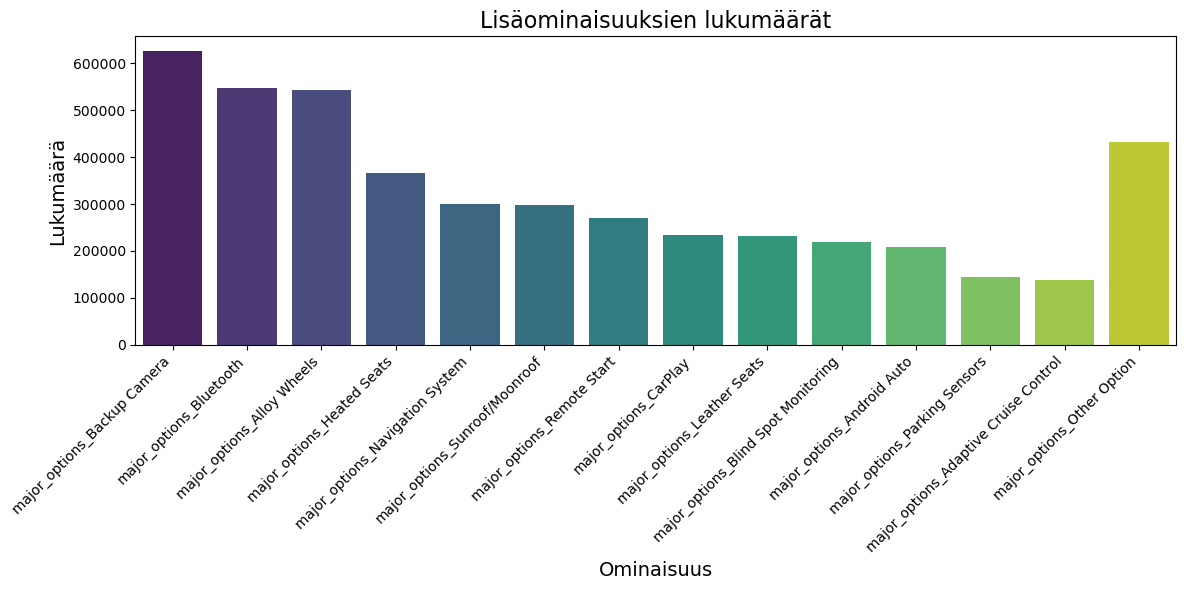

In [43]:
import seaborn as sns

major_options_cols = cleaned_df2.filter(like='major_options').columns

option_counts = cleaned_df2[major_options_cols].sum()

plt.figure(figsize=(12,6))
sns.barplot(x=option_counts.index, y=option_counts.values, palette="viridis")

plt.title("Lisäominaisuuksien lukumäärät", fontsize=16)
plt.xlabel("Ominaisuus", fontsize=14)
plt.ylabel("Lukumäärä", fontsize=14)
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()



## Poikkeavien arvojen tunnistaminen (Outliers)

Tulostetaan jokaisen numeerisen sarakkeen:
* Alimmat ja ylimmät poikkeavat arvot ja ylimmät poikkeavat arvot
* Jos arvoja ei ole, se tarkoittaa ettei poikkevia arvoja löydy halutun rajan alapuolelta. Tämä riippuu datan jakaumasta.
* head näyttää viisi ensimmäistä poikkeamaa jotka löytyvät, pitää miettiä onko tämä paras ratkaisu. Alla mahd. ratkaisu.

```
min_outliers = df[df[col] < lower_bound]
max_outliers = df[df[col] > upper_bound]

outlier_rows[col] = {
    'min_count': len(min_outliers),
    'max_count': len(max_outliers),
    'min_outliers_head': min_outliers.nsmallest(5, col)[col],  # 5 pienintä poikkeamaa
    'max_outliers_head': max_outliers.nlargest(5, col)[col]   # 5 suurinta poikkeamaa
}
```

* Mahdollisesti vielä kuvan lisäys

In [44]:
# Säilytetään hyyväksi todetut sarakkeet
columns_to_keep = [
    'back_legroom', 'daysonmarket', 'engine_displacement', 'front_legroom', 
    'fuel_tank_volume', 'height', 'horsepower', 'length', 'listed_date', 
    'maximum_seating', 'mileage', 'price', 'savings_amount', 'seller_rating', 
    'wheelbase', 'width', 'year', 'listed_year', 'listed_month'
]

# Luodaan uusi DataFrame vain säilytettävillä sarakkeilla
outlier_test_df = cleaned_df2[columns_to_keep].copy()

# Vaihdettiin outlier menetelmä IQR sillä se on ymmärtääkseni parempi kun data ei ole vielä normaalisti jakautunut ja se ei ole niiin riippuvainen äärimmäisistä arvoista
def check_outliers_iqr(df):
    outlier_rows = {}
    for col in df.select_dtypes(include=['number']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        min_outliers = df[df[col] < lower_bound]
        max_outliers = df[df[col] > upper_bound]
        outlier_rows[col] = {
            'min_count': len(min_outliers),
            'max_count': len(max_outliers),
            'min_outliers_head': min_outliers.head()[col],
            'max_outliers_head': max_outliers.head()[col]
        }
    return outlier_rows

outlier_info_iqr = check_outliers_iqr(outlier_test_df)

# Tulostetaan poikkeamien tulokset luettavasti
for col, info in outlier_info_iqr.items():
    print(f"Sarake: {col}")
    print(f"  - Alle alemman rajan poikkeamat: (5)")
    print(info['min_outliers_head'])
    print(f"  - Yli ylemmän rajan poikkeamat: (5)")
    print(info['max_outliers_head'])
    print('-' * 40)


Sarake: back_legroom
  - Alle alemman rajan poikkeamat: (5)
40     27.3
71     27.1
131    29.9
165    29.9
267    29.9
Name: back_legroom, dtype: float64
  - Yli ylemmän rajan poikkeamat: (5)
663     45.2
1148    45.2
1291    45.2
1305    45.2
1403    45.2
Name: back_legroom, dtype: float64
----------------------------------------
Sarake: daysonmarket
  - Alle alemman rajan poikkeamat: (5)
Series([], Name: daysonmarket, dtype: int64)
  - Yli ylemmän rajan poikkeamat: (5)
0    522
1    207
5    242
6    447
8    196
Name: daysonmarket, dtype: int64
----------------------------------------
Sarake: engine_displacement
  - Alle alemman rajan poikkeamat: (5)
Series([], Name: engine_displacement, dtype: float64)
  - Yli ylemmän rajan poikkeamat: (5)
98     6200.0
115    6200.0
165    6200.0
184    6700.0
222    6200.0
Name: engine_displacement, dtype: float64
----------------------------------------
Sarake: front_legroom
  - Alle alemman rajan poikkeamat: (5)
1610    37.7
1787    35.8
1788 

# Datan visualisointeja

100%|██████████| 796451/796451 [00:18<00:00, 42856.58it/s]


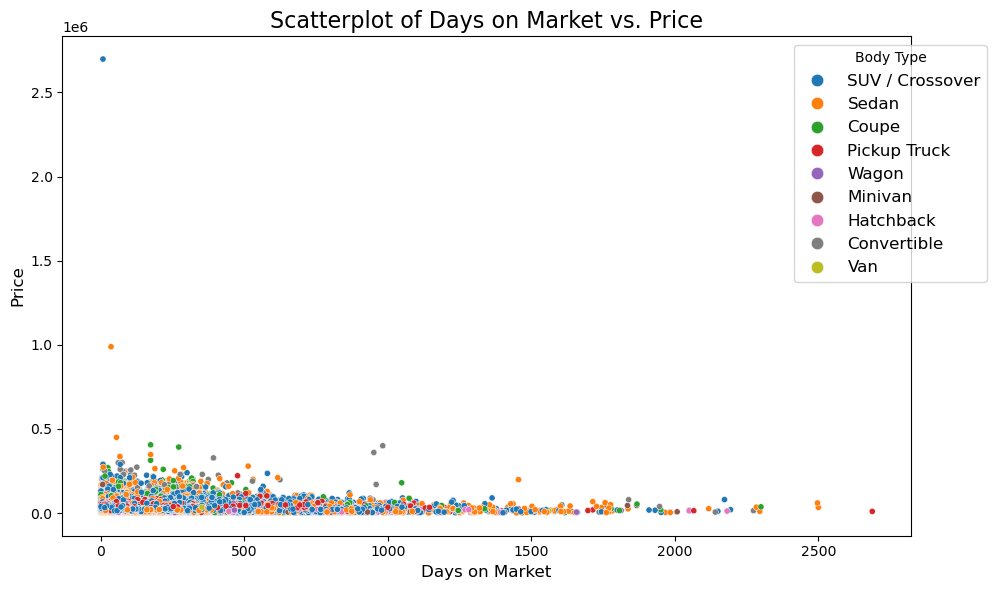

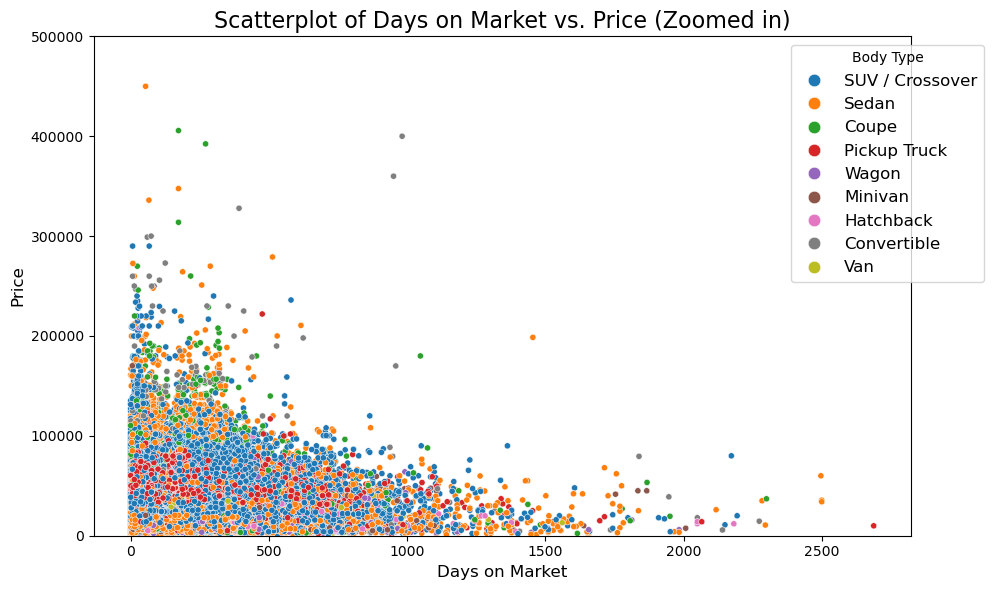

In [45]:
import seaborn as sns
# Ensure tqdm works with pandas apply
tqdm.pandas()

# Identify all columns starting with 'body_'
body_columns = [col for col in cleaned_df2.columns if col.startswith('body_')]

# Create a new column 'body_color' that will store the color for each point
def assign_color(row):
    # Check which 'body_' column has a True value and assign the column name as the color
    for col in body_columns:
        if row[col] == True:
            return col  # Use the column name as the color
    return 'gray'  # Default color for rows with no True values

# Apply the function to create the 'body_color' column with a progress bar
cleaned_df2['body_color'] = cleaned_df2.progress_apply(assign_color, axis=1)

# Create the first scatterplot (entire range)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='daysonmarket', y='price', data=cleaned_df2, hue='body_color', palette='tab10', legend='full', s=20)  # Adjusted size with s=20

# Set the title and labels for the first plot
plt.title('Scatterplot of Days on Market vs. Price', fontsize=16)
plt.xlabel('Days on Market', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Customize the legend
handles, labels = plt.gca().get_legend_handles_labels()
# Update the legend labels to show in the desired format
new_labels = [label.replace('body_type_', '') for label in labels]

# Increase the size of the legend markers
plt.legend(handles=handles, labels=new_labels, title='Body Type', loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=12, markerscale=2)

# Show the first plot
plt.tight_layout()
plt.show()

# Create the second scatterplot (zoomed-in on price)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='daysonmarket', y='price', data=cleaned_df2, hue='body_color', palette='tab10', legend='full', s=20)  # Adjusted size with s=20

# Set the title and labels for the second plot
plt.title('Scatterplot of Days on Market vs. Price (Zoomed in)', fontsize=16)
plt.xlabel('Days on Market', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Zoom into the price axis (limit to 500,000)
plt.ylim(0, 500000)

# Customize the legend again
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [label.replace('body_type_', '') for label in labels]

# Increase the size of the legend markers
plt.legend(handles=handles, labels=new_labels, title='Body Type', loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=12, markerscale=2)

# Show the second plot
plt.tight_layout()
plt.show()


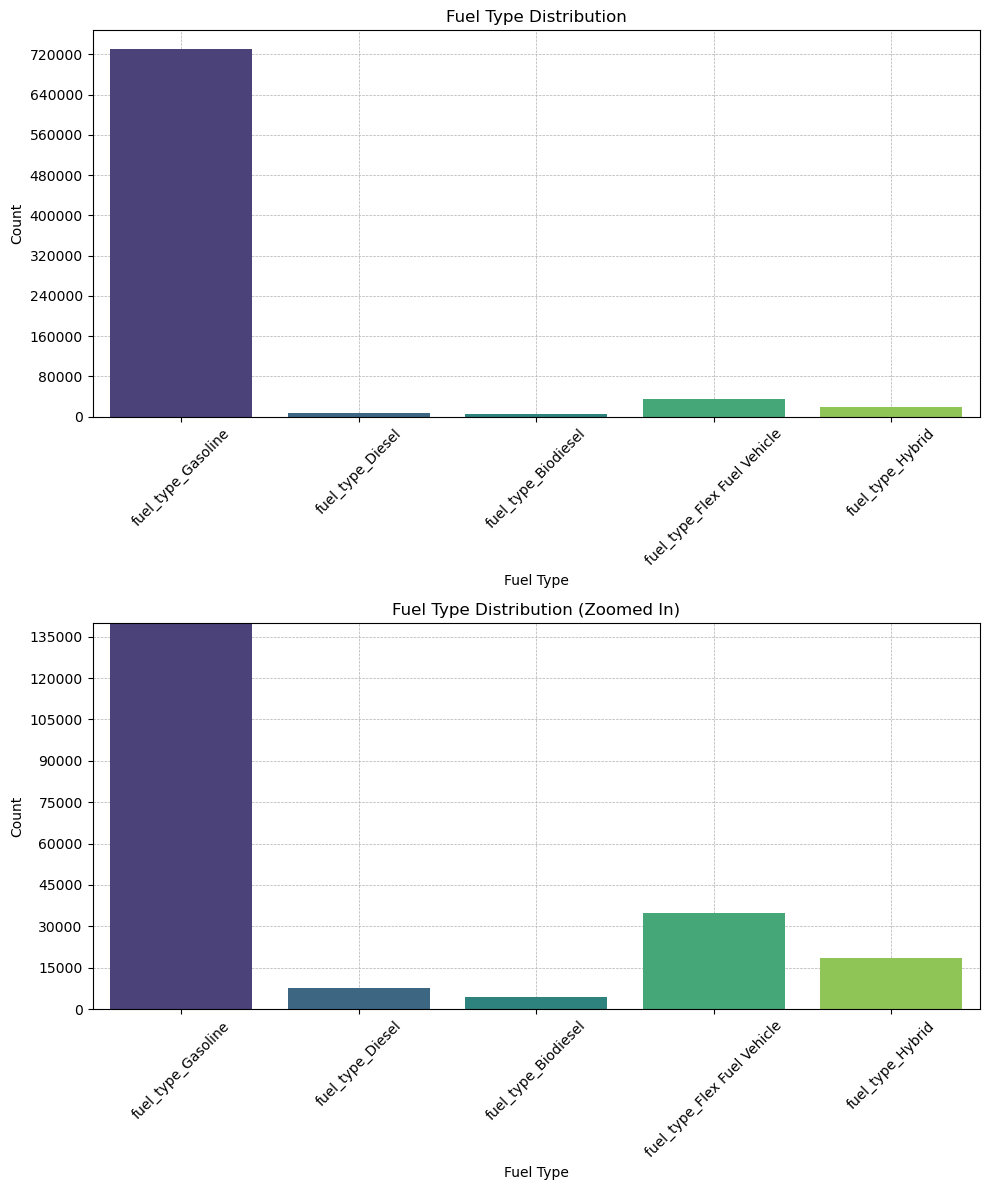

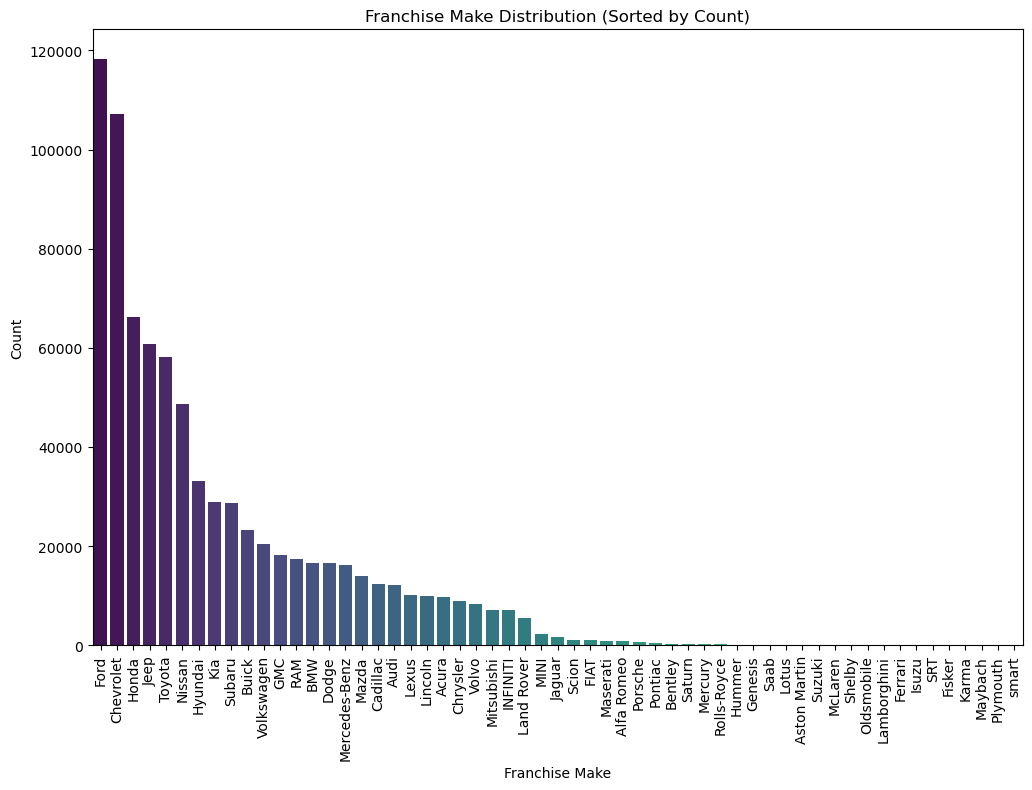

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# fuel_type_columns after one-hot encoding
fuel_type_columns = ['fuel_type_Biodiesel', 'fuel_type_Diesel', 'fuel_type_Flex Fuel Vehicle', 'fuel_type_Gasoline', 'fuel_type_Hybrid']

# Create new 'fuel_type' column, tells fueltype
cleaned_df2['fuel_type'] = cleaned_df2[fuel_type_columns].idxmax(axis=1)

# Create a 2x1 grid for the subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot the full distribution of fuel types
sns.countplot(x='fuel_type', data=cleaned_df2, palette='viridis', ax=axes[0], zorder=2)
axes[0].set_title('Fuel Type Distribution')
axes[0].set_xlabel('Fuel Type')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5, zorder=1)

# Plot the zoomed-in distribution (up to 200,000)
sns.countplot(x='fuel_type', data=cleaned_df2, palette='viridis', ax=axes[1], zorder=2)
axes[1].set_title('Fuel Type Distribution (Zoomed In)')
axes[1].set_xlabel('Fuel Type')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
# Set the y-axis limit for zoom
axes[1].set_ylim(0, 140000)
axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5, zorder=1)


plt.tight_layout()
plt.show()

# Get sorted value counts for franchise_make
sorted_make_counts = cleaned_df2['franchise_make'].value_counts().sort_values(ascending=False)

# Plot sorted distribution of franchise makes
plt.figure(figsize=(12, 8))
sns.countplot(x='franchise_make', data=cleaned_df2, order=sorted_make_counts.index, palette='viridis')
plt.title('Franchise Make Distribution (Sorted by Count)')
plt.xlabel('Franchise Make')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if necessary
plt.show()

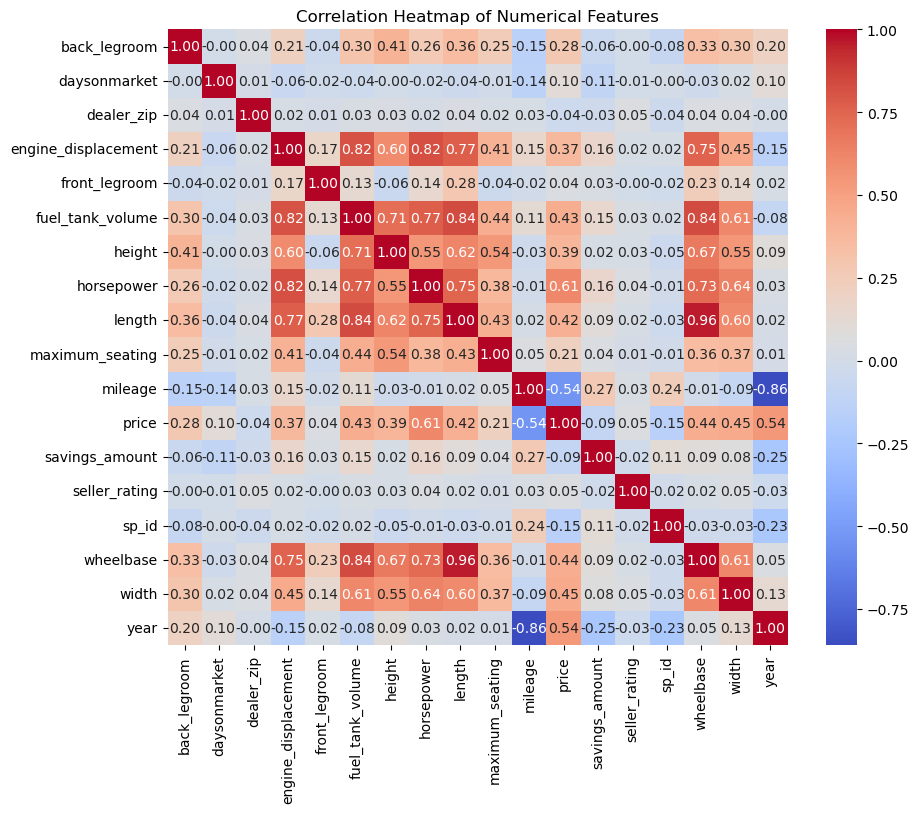

In [47]:
# Select numerical features for correlation heatmap
#numerical_columns = cleaned_df2.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = [col for col in cleaned_df2.select_dtypes(include=['float64', 'int64']).columns if not col.startswith('major_options')]
corr_matrix = cleaned_df2[numerical_columns].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [48]:
from collections import defaultdict
boolean_columns = cleaned_df2.dtypes == 'bool'
bool_columns_list = cleaned_df2.columns[boolean_columns].tolist()

grouped_columns = defaultdict(list)
for col in bool_columns_list:
    prefix = col.split('_')[0]  # Extract prefix (substring before the first '_')
    grouped_columns[prefix].append(col)

# Convert defaultdict to a regular dictionary for easier reading
grouped_columns = dict(grouped_columns)

# Display the grouped columns
for group, items in grouped_columns.items():
    print(f"{group}: {items}")

fleet: ['fleet']
frame: ['frame_damaged']
franchise: ['franchise_dealer']
has: ['has_accidents']
isCab: ['isCab']
is: ['is_new']
salvage: ['salvage']
theft: ['theft_title']
fuel: ['fuel_type_Biodiesel', 'fuel_type_Compressed Natural Gas', 'fuel_type_Diesel', 'fuel_type_Flex Fuel Vehicle', 'fuel_type_Gasoline', 'fuel_type_Hybrid']
wheel: ['wheel_4X2', 'wheel_All-Wheel Drive', 'wheel_Four-Wheel Drive', 'wheel_Front-Wheel Drive', 'wheel_Rear-Wheel Drive']
transmission: ['transmission_A', 'transmission_CVT', 'transmission_Dual Clutch', 'transmission_M']
body: ['body_type_Convertible', 'body_type_Coupe', 'body_type_Hatchback', 'body_type_Minivan', 'body_type_Pickup Truck', 'body_type_SUV / Crossover', 'body_type_Sedan', 'body_type_Van', 'body_type_Wagon']
listing: ['listing_color_black, unknown', 'listing_color_purple, pink, teal', 'listing_color_red, blue, green, brown', 'listing_color_white, gray, silver', 'listing_color_yellow, orange, gold']


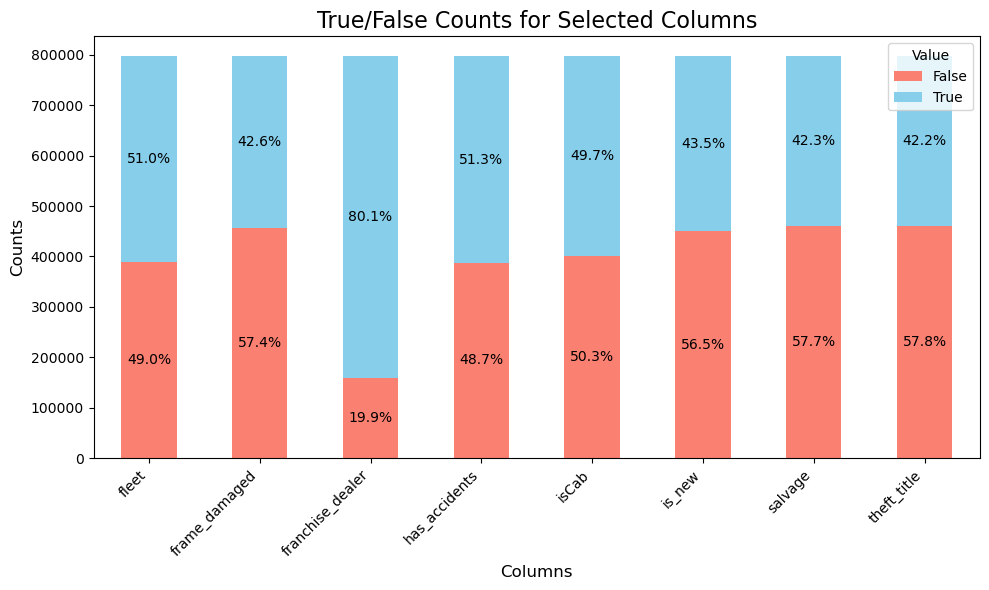

In [49]:
# Define the specific columns
columns = ['fleet', 'frame_damaged', 'franchise_dealer', 'has_accidents', 'isCab', 'is_new', 'salvage', 'theft_title']

# Count True and False values for each column
counts = cleaned_df2[columns].apply(pd.Series.value_counts).fillna(0).astype(int)

# Transpose the counts DataFrame for better plotting (columns become True/False, and indices are the specific column names)
counts = counts.T  # This makes the rows as columns and columns as values

# Plotting the stacked bar chart
ax = counts.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(10, 6))

# Customize the plot
plt.title('True/False Counts for Selected Columns', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.legend(title='Value', labels=['False', 'True'])

# Display percentages on top of the bars
for i, p in enumerate(ax.patches):
    # Get the total count for each column (True + False)
    total = counts.iloc[i // 2].sum()  # Each column has two bars (True, False), so divide by 2 to get the correct row index
    height = p.get_height()
    
    # Calculate the percentage
    percentage = (height / total) * 100
    
    # Calculate the x-position for each bar and display the percentage text
    x_position = p.get_x() + p.get_width() / 2
    y_position = p.get_y() + height / 2  # Place text in the middle of the bar
    
    ax.text(
        x_position, y_position, f'{percentage:.1f}%', ha='center', va='center', fontsize=10, color='black'
    )

plt.tight_layout()  # Adjust layout to fit all elements
plt.show()


In [50]:
# Count the number of True and False values in the 'fleet' column
true_count_fleet = cleaned_df2['fleet'].value_counts().get(True, 0)
false_count_fleet = cleaned_df2['fleet'].value_counts().get(False, 0)

print(f"Number of True values in 'fleet': {true_count_fleet}")
print(f"Number of False values in 'fleet': {false_count_fleet}")

Number of True values in 'fleet': 406471
Number of False values in 'fleet': 389980


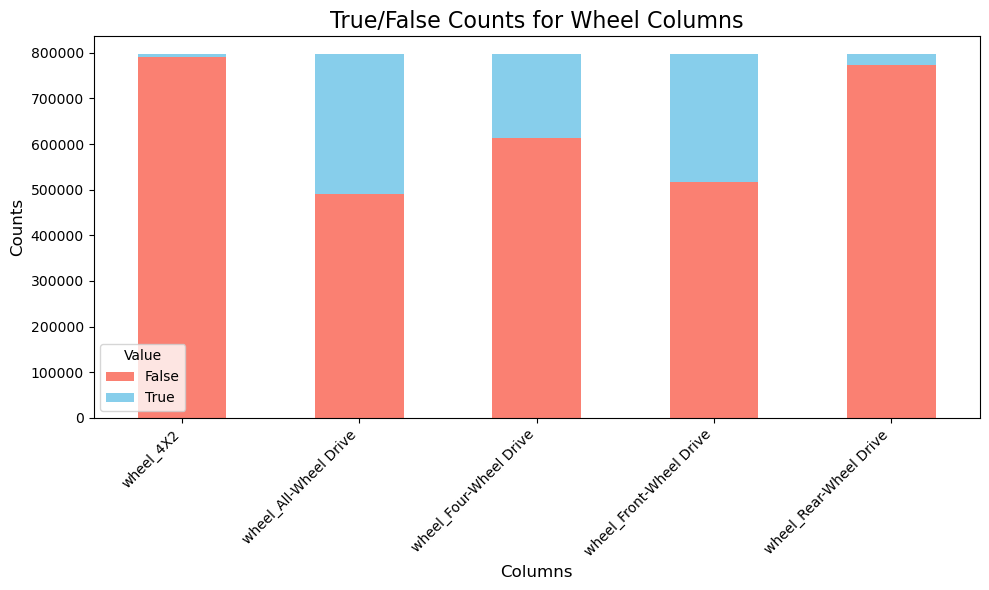

In [51]:
# Filter columns that start with 'wheel'
wheel_columns = [col for col in cleaned_df2.columns if col.startswith('wheel_')]

# Count True and False values for each column
counts = cleaned_df2[wheel_columns].apply(pd.Series.value_counts).fillna(0).astype(int)

# Transpose the counts DataFrame for better plotting
counts = counts.T  # Columns become 'True' and 'False', and indices are 'wheel_*'

# Plotting the stacked bar chart
counts.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(10, 6))

# Customize the plot
plt.title('True/False Counts for Wheel Columns', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.legend(title='Value', labels=['False', 'True'])
plt.tight_layout()  # Adjust layout to fit all elements

# Show the plot
plt.show()

Processing group: Wheel Columns
True counts for Wheel Columns: wheel_All-Wheel Drive      305045
wheel_Four-Wheel Drive     183777
wheel_Front-Wheel Drive    278987
Other                       28642
dtype: int64


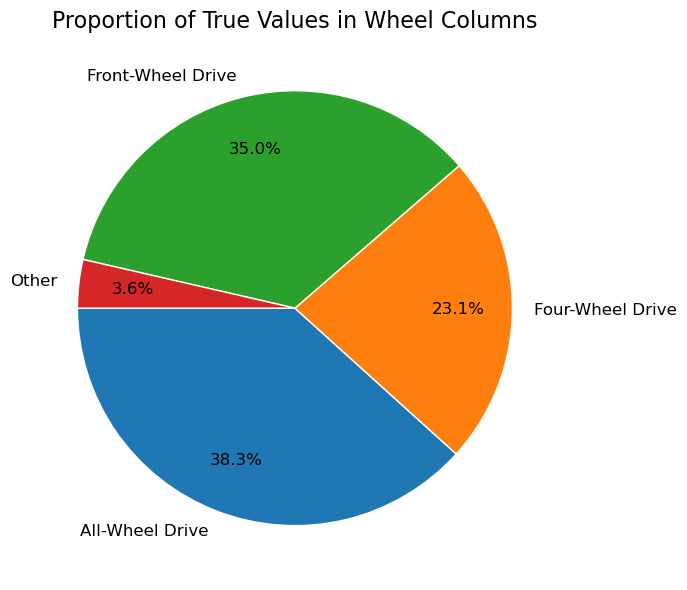

Completed group: Wheel Columns
Processing group: Transmission Columns
True counts for Transmission Columns: transmission_A      646977
transmission_CVT    133946
Other                15528
dtype: int64


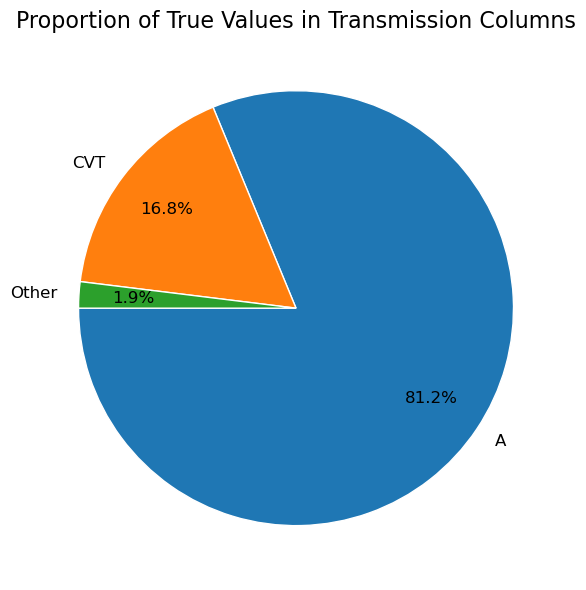

Completed group: Transmission Columns
Processing group: Body Type Columns
True counts for Body Type Columns: body_type_Pickup Truck        95411
body_type_SUV / Crossover    424629
body_type_Sedan              201613
Other                         74798
dtype: int64


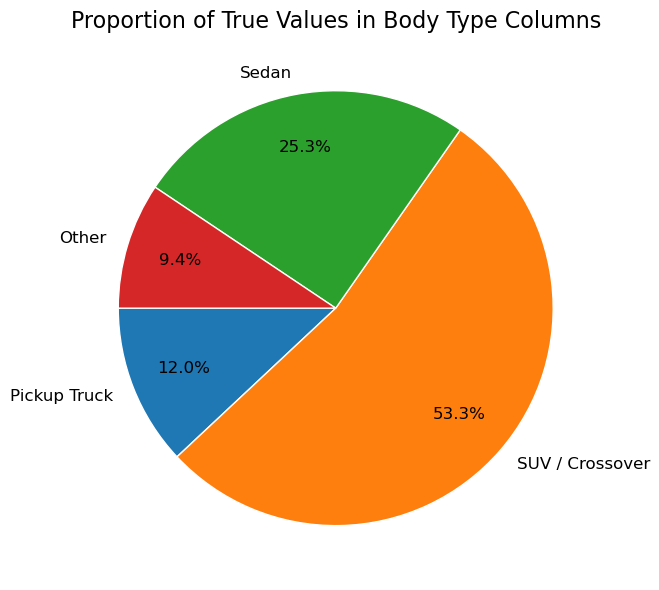

Completed group: Body Type Columns
Processing group: Listing Color Columns
True counts for Listing Color Columns: listing_color_black, unknown             275547
listing_color_red, blue, green, brown    156518
listing_color_white, gray, silver        355501
Other                                      8885
dtype: int64


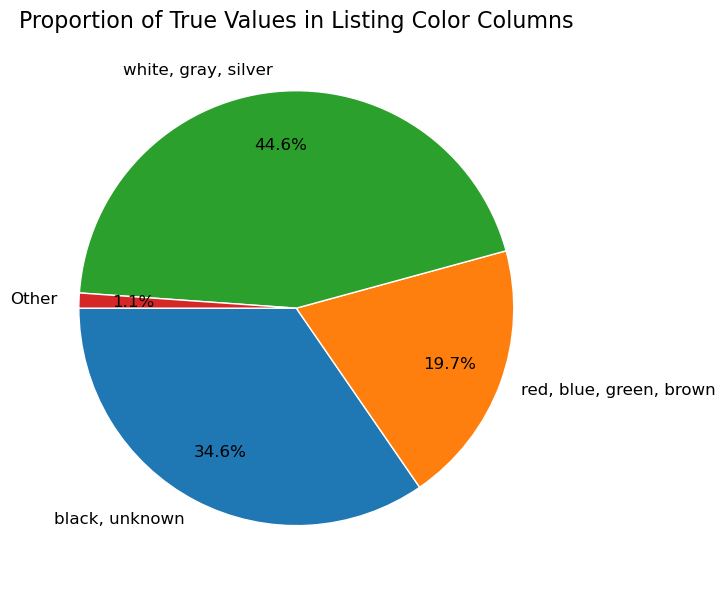

Completed group: Listing Color Columns
Processing group: Major Options Columns
True counts for Major Options Columns: major_options_Backup Camera              626504
major_options_Bluetooth                  547604
major_options_Alloy Wheels               543412
major_options_Heated Seats               366022
major_options_Navigation System          301217
major_options_Sunroof/Moonroof           298929
major_options_Remote Start               270836
major_options_CarPlay                    234517
major_options_Leather Seats              231104
major_options_Blind Spot Monitoring      220052
major_options_Android Auto               207527
major_options_Parking Sensors            144018
major_options_Adaptive Cruise Control    137637
major_options_Other Option               432883
dtype: int64


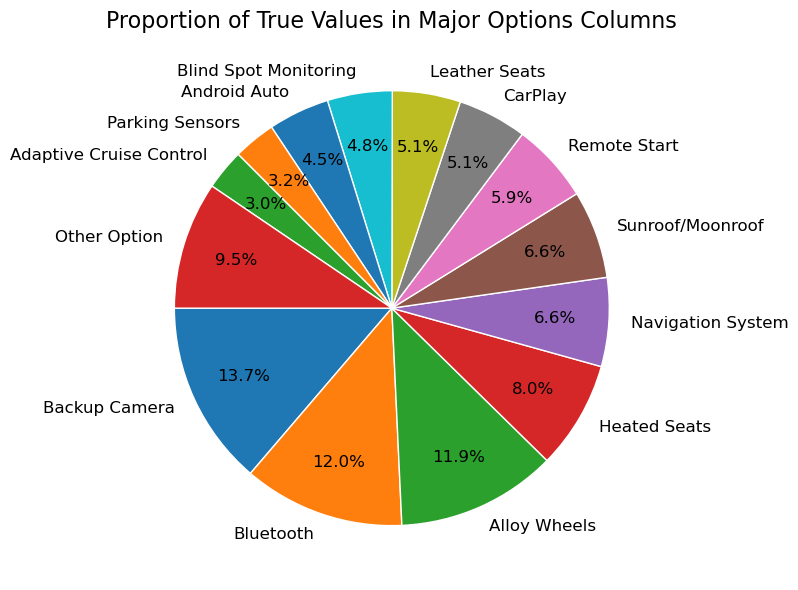

Completed group: Major Options Columns
All groups processed.


In [52]:

# Function to process data and group small percentages into 'Other'
def process_data_for_pie(true_counts):
    total = true_counts.sum()
    percentages = (true_counts / total) * 100
    small_values = percentages < 3  # Threshold for small percentages
    if small_values.any():
        other_value = true_counts[small_values].sum()
        true_counts = true_counts[~small_values]
        true_counts['Other'] = other_value
    return true_counts

# Define prefixes for each group
groups = {
    'wheel_': 'Wheel Columns',
    'transmission_': 'Transmission Columns',
    'body_type_': 'Body Type Columns',
    'listing_color_': 'Listing Color Columns',
    'major_options_': 'Major Options Columns'
}

# Loop through each group and create pie charts
for prefix, title in groups.items():
    print(f"Processing group: {title}")
    
    # Filter columns that start with the prefix
    group_columns = [col for col in cleaned_df2.columns if col.startswith(prefix)]
    
    if not group_columns:
        print(f"No columns found for prefix: {prefix}")
        continue
    
    # Count the True values for each column
    true_counts = cleaned_df2[group_columns].sum()
    
    # Process data for pie chart (combine small percentages into "Other")
    true_counts = process_data_for_pie(true_counts)
    
    print(f"True counts for {title}: {true_counts}")
    
    plt.figure(figsize=(8, 6))
    plt.pie(
        true_counts, 
        labels=true_counts.index.str.replace(prefix, ''), 
        autopct='%1.1f%%', 
        startangle=180, 
        colors=plt.cm.tab10.colors[:len(true_counts)],
        textprops={'fontsize': 12},
        pctdistance=0.75,  # Adjust percentage text to be closer to the center
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    )
    plt.title(f'Proportion of True Values in {title}', fontsize=16)
    plt.tight_layout()
    plt.show()
    print(f"Completed group: {title}")

print("All groups processed.")


# Label Encoding

Enkoodataan kategoriset muuttujat numeerisiksi arvoiksi, jotta voidaan viedä myöhemmin käytettävälle koneoppimismallille. Tämä tehdään sarakkeille, joissa oli liian paljon uniikkeja kategorisia muuttujia, jotta one-hot enkoodausta olisi voitu käyttää.

Tehdään sarakkeille:
- fuel_type
- make
- city
- model



In [53]:
from sklearn.preprocessing import LabelEncoder

fuel_type_encoder = LabelEncoder()
make_encoder = LabelEncoder()
city_encoder = LabelEncoder()
model_encoder = LabelEncoder()

#enkoodataan, niin monta saraketta
cleaned_df2['fuel_type_encoded'] = city_encoder.fit_transform(cleaned_df2['fuel_type'])
cleaned_df2['make_encoded'] = make_encoder.fit_transform(cleaned_df2['franchise_make'])
cleaned_df2['city_encoded'] = city_encoder.fit_transform(cleaned_df2['city'])
cleaned_df2['model_encoded'] = model_encoder.fit_transform(cleaned_df2['model_name'])

### Encoding "major_options" -sarakkeelle

- Tämä toisena vaihtoehtona aiemmin tehtyyn one-hot encodingiin

In [54]:
dataframe.columns
print(dataframe["major_options"].sample(20))
print(dataframe["major_options"].nunique())

422452                                                  NaN
766424       ['Leather Seats', 'Alloy Wheels', 'Bluetooth']
409933    ['Alloy Wheels', 'Bluetooth', 'Backup Camera',...
452356    ['Alloy Wheels', 'Bluetooth', 'Backup Camera',...
316494    ['Sunroof/Moonroof', 'Safety Package', 'SE Pac...
899821                    ['Leather Seats', 'Alloy Wheels']
803765    ['Leather Seats', 'Sunroof/Moonroof', 'Navigat...
584068    ['Leather Seats', 'Sunroof/Moonroof', 'Backup ...
110592    ['Alloy Wheels', 'Appearance Package', 'Blueto...
536494    ['Alloy Wheels', 'Third Row Seating', 'Bluetoo...
768494                                        ['Bluetooth']
682710    ['Leather Seats', '301A Mid Equipment Group', ...
101021    ['Bluetooth', 'Backup Camera', 'Parking Sensor...
937349                                     ['Alloy Wheels']
418057    ['Leather Seats', 'Sunroof/Moonroof', 'Navigat...
737857    ['Sunroof/Moonroof', 'Alloy Wheels', 'Bluetoot...
664830    ['Navigation System', 'Adaptiv

In [55]:
import pandas as pd
import ast

# Muutetaan sarakkeen merkkijonot listaksi (jos tarpeen)
dataframe["major_options"] = dataframe["major_options"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Luodaan numeerinen koodaus jokaiselle varusteelle
all_options = sorted(set(option for sublist in dataframe["major_options"].dropna() for option in sublist))
option_to_id = {option: idx for idx, option in enumerate(all_options)}

# Korvataan varusteet numeerisilla koodeilla
dataframe["encoded_options"] = dataframe["major_options"].apply(
    lambda x: [option_to_id[option] for option in x] if isinstance(x, list) else []
)

print(dataframe["encoded_options"].sample(20))


545439                                         [25, 50, 68]
497351       [58, 121, 12, 15, 125, 25, 22, 24, 97, 50, 27]
273133                                                   []
632630             [58, 70, 15, 25, 22, 24, 29, 50, 17, 27]
791109                                     [58, 15, 25, 50]
792824                                                 [58]
528276                                 [58, 15, 25, 22, 50]
898071                                [15, 125, 25, 22, 97]
800852                            [15, 125, 22, 75, 17, 27]
588290                                                 [22]
394086                            [121, 12, 15, 25, 22, 50]
347958    [58, 121, 70, 12, 15, 25, 22, 24, 97, 75, 50, 93]
928184                   [121, 70, 15, 125, 22, 50, 17, 27]
600358                             [15, 22, 29, 50, 17, 27]
262700                                                [119]
661598                           [121, 70, 15, 125, 22, 50]
291695                                  

# Mallille vietavien sarakkeiden viimeistelyt

- Poistetaan vielä "make_name" -sarake sillä sisältää vähemmän tietoja kuin "franchise_make"

In [56]:
print(len(cleaned_df2['franchise_make'].unique()))
print(len(cleaned_df2['make_name'].unique()))
list1 = cleaned_df2['franchise_make'].unique()
list2 = cleaned_df2['make_name'].unique()

unique_to_list1 = set(list1) - set(list2)
print(unique_to_list1)

57
51
{'McLaren', 'Ferrari', 'SRT', 'Shelby', 'Lamborghini', 'Lotus', 'smart'}


- Sarakkeet, jotka jätetään pois mallintamisen vaiheessa 
- Tekstipohjaiset visuaalisaation jälkeen poistettava

Poistettavat sarakkeet:
- listing_color
- make_name
- fuel_type
- franchise_make
- city
- model_name

Nämä on enkoodattu, joten nyt poistetaan vain alkuperäiset sarakkeet

In [57]:
pudotettavat = ['listing_color', 'make_name', 'body_color']
enkoodatut = ['fuel_type', 'franchise_make', 'city', 'model_name'] #jatkon kannalta talteen

cleaned_df2.drop(columns=pudotettavat, inplace=True)
cleaned_df2.drop(columns=enkoodatut, inplace=True)

final_df = cleaned_df2
final_df.head(2)

,back_legroom,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,front_legroom,fuel_tank_volume,has_accidents,height,horsepower,isCab,is_new,length,listed_date,maximum_seating,mileage,price,salvage,savings_amount,seller_rating,sp_id,theft_title,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,fuel_type_Biodiesel,fuel_type_Compressed Natural Gas,fuel_type_Diesel,fuel_type_Flex Fuel Vehicle,fuel_type_Gasoline,fuel_type_Hybrid,wheel_4X2,wheel_All-Wheel Drive,wheel_Four-Wheel Drive,wheel_Front-Wheel Drive,wheel_Rear-Wheel Drive,transmission_A,transmission_CVT,transmission_Dual Clutch,transmission_M,body_type_Convertible,body_type_Coupe,body_type_Hatchback,body_type_Minivan,body_type_Pickup Truck,body_type_SUV / Crossover,body_type_Sedan,body_type_Van,body_type_Wagon,"listing_color_black, unknown","listing_color_purple, pink, teal","listing_color_red, blue, green, brown","listing_color_white, gray, silver","listing_color_yellow, orange, gold",major_options_Backup Camera,major_options_Bluetooth,major_options_Alloy Wheels,major_options_Heated Seats,major_options_Navigation System,major_options_Sunroof/Moonroof,major_options_Remote Start,major_options_CarPlay,major_options_Leather Seats,major_options_Blind Spot Monitoring,major_options_Android Auto,major_options_Parking Sensors,major_options_Adaptive Cruise Control,major_options_Other Option,fuel_type_encoded,make_encoded,city_encoded,model_encoded
0,35.1,522,960.0,1300.0,True,True,True,41.2,12.7,True,66.5,177.0,True,True,166.6,2019-04-06,5.0,7.0,23141.0,True,0,2.8,370599.0,True,101.2,79.6,2019,2019,4,5,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,23,140,606
1,38.1,207,922.0,2000.0,True,True,True,39.1,17.7,True,68.0,246.0,True,True,181.0,2020-02-15,7.0,8.0,46500.0,True,0,3.0,389227.0,True,107.9,85.6,2020,2020,2,5,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,27,2350,209


## Boolean-sarakkeet int:ksi

- Muunnetaan boolean-tyyppiset sarakkeet 0/1 muotoon True/False sijaan koko datasetissä

In [58]:
# Valitaan bool-sarakkeet
bool_columns = final_df.select_dtypes(include=["bool"]).columns

# Muunnetaan 0/1 muotoon
final_df[bool_columns] = final_df[bool_columns].astype(int)

final_df[bool_columns].head()


,fleet,frame_damaged,franchise_dealer,has_accidents,isCab,is_new,salvage,theft_title,fuel_type_Biodiesel,fuel_type_Compressed Natural Gas,fuel_type_Diesel,fuel_type_Flex Fuel Vehicle,fuel_type_Gasoline,fuel_type_Hybrid,wheel_4X2,wheel_All-Wheel Drive,wheel_Four-Wheel Drive,wheel_Front-Wheel Drive,wheel_Rear-Wheel Drive,transmission_A,transmission_CVT,transmission_Dual Clutch,transmission_M,body_type_Convertible,body_type_Coupe,body_type_Hatchback,body_type_Minivan,body_type_Pickup Truck,body_type_SUV / Crossover,body_type_Sedan,body_type_Van,body_type_Wagon,"listing_color_black, unknown","listing_color_purple, pink, teal","listing_color_red, blue, green, brown","listing_color_white, gray, silver","listing_color_yellow, orange, gold"
0,1,1,1,1,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,1,1,1,1,1,1,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,1,1,1,1,1,1,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
5,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
6,1,1,1,1,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [60]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 796451 entries, 0 to 999999
Data columns (total 77 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   back_legroom                           796451 non-null  float64       
 1   daysonmarket                           796451 non-null  int64         
 2   dealer_zip                             796451 non-null  float64       
 3   engine_displacement                    796451 non-null  float64       
 4   fleet                                  796451 non-null  int32         
 5   frame_damaged                          796451 non-null  int32         
 6   franchise_dealer                       796451 non-null  int32         
 7   front_legroom                          796451 non-null  float64       
 8   fuel_tank_volume                       796451 non-null  float64       
 9   has_accidents                          796451 non-nul

### Kuvaaja, jossa lopullinen jakauma tietotyypeistä

- Huomataan, että objekti-tietotyypeistä on päästy kokonaan eroon

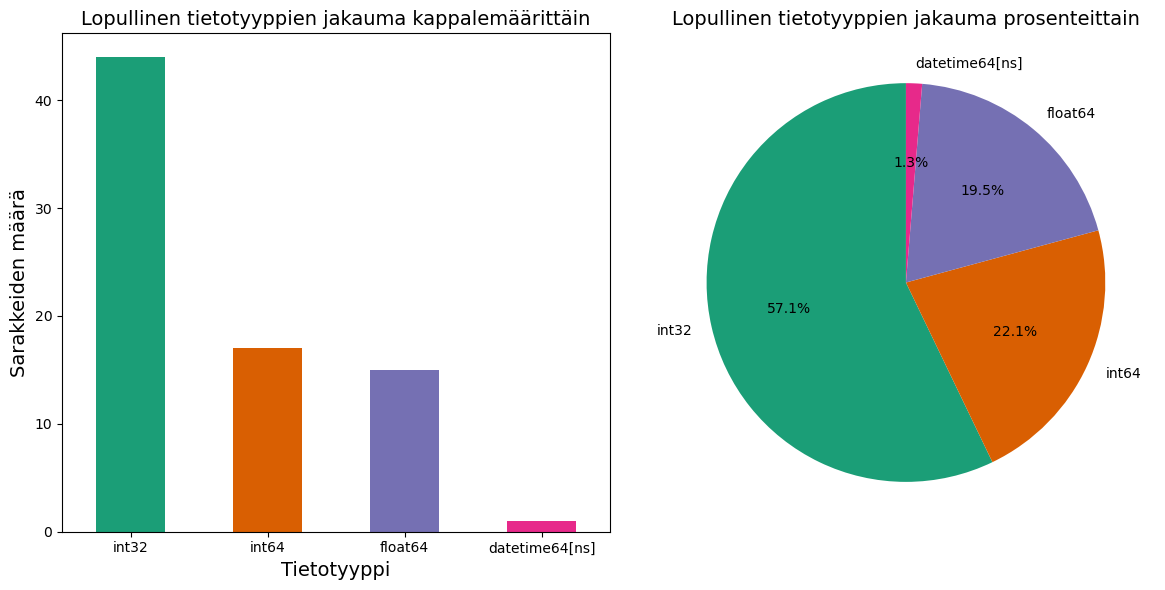

In [61]:
import matplotlib.pyplot as plt

data_types_plot3 = cleaned_df2.dtypes.value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Barplot
data_types_plot3.plot(
    kind="bar",
    ax=axes[0],
    color=colors
)

axes[0].tick_params(axis="x", rotation=0)
axes[0].set_title("Lopullinen tietotyyppien jakauma kappalemäärittäin", fontsize=14)
axes[0].set_xlabel("Tietotyyppi", fontsize=14)
axes[0].set_ylabel("Sarakkeiden määrä", fontsize=14)

# Pie
data_types_plot3.plot(
    kind="pie",
    ax=axes[1],
    autopct="%1.1f%%",
    startangle=90,
    ylabel="",
    colors=colors
)

axes[1].set_title("Lopullinen tietotyyppien jakauma prosenteittain", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

## Datan skaalaaminen

- Katsotaan mitä final_df pitää sisällään ennen skaalausta

In [62]:
print(final_df.info())

print(final_df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 796451 entries, 0 to 999999
Data columns (total 77 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   back_legroom                           796451 non-null  float64       
 1   daysonmarket                           796451 non-null  int64         
 2   dealer_zip                             796451 non-null  float64       
 3   engine_displacement                    796451 non-null  float64       
 4   fleet                                  796451 non-null  int32         
 5   frame_damaged                          796451 non-null  int32         
 6   franchise_dealer                       796451 non-null  int32         
 7   front_legroom                          796451 non-null  float64       
 8   fuel_tank_volume                       796451 non-null  float64       
 9   has_accidents                          796451 non-nul

In [63]:
display(final_df.head())

,back_legroom,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,front_legroom,fuel_tank_volume,has_accidents,height,horsepower,isCab,is_new,length,listed_date,maximum_seating,mileage,price,salvage,savings_amount,seller_rating,sp_id,theft_title,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,fuel_type_Biodiesel,fuel_type_Compressed Natural Gas,fuel_type_Diesel,fuel_type_Flex Fuel Vehicle,fuel_type_Gasoline,fuel_type_Hybrid,wheel_4X2,wheel_All-Wheel Drive,wheel_Four-Wheel Drive,wheel_Front-Wheel Drive,wheel_Rear-Wheel Drive,transmission_A,transmission_CVT,transmission_Dual Clutch,transmission_M,body_type_Convertible,body_type_Coupe,body_type_Hatchback,body_type_Minivan,body_type_Pickup Truck,body_type_SUV / Crossover,body_type_Sedan,body_type_Van,body_type_Wagon,"listing_color_black, unknown","listing_color_purple, pink, teal","listing_color_red, blue, green, brown","listing_color_white, gray, silver","listing_color_yellow, orange, gold",major_options_Backup Camera,major_options_Bluetooth,major_options_Alloy Wheels,major_options_Heated Seats,major_options_Navigation System,major_options_Sunroof/Moonroof,major_options_Remote Start,major_options_CarPlay,major_options_Leather Seats,major_options_Blind Spot Monitoring,major_options_Android Auto,major_options_Parking Sensors,major_options_Adaptive Cruise Control,major_options_Other Option,fuel_type_encoded,make_encoded,city_encoded,model_encoded
0,35.1,522,960.0,1300.0,1,1,1,41.2,12.7,1,66.5,177.0,1,1,166.6,2019-04-06,5.0,7.0,23141.0,1,0,2.8,370599.0,1,101.2,79.6,2019,2019,4,5,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,23,140,606
1,38.1,207,922.0,2000.0,1,1,1,39.1,17.7,1,68.0,246.0,1,1,181.0,2020-02-15,7.0,8.0,46500.0,1,0,3.0,389227.0,1,107.9,85.6,2020,2020,2,5,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,27,2350,209
4,38.1,137,922.0,2000.0,1,1,1,39.1,17.7,1,68.0,246.0,1,1,181.0,2020-04-25,7.0,7.0,48880.0,1,0,3.0,389227.0,1,107.9,85.6,2020,2020,4,5,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,27,2350,209
5,37.1,242,922.0,2000.0,0,0,1,40.2,16.6,0,66.3,247.0,0,1,188.9,2020-01-11,5.0,12.0,66903.0,0,0,3.0,389227.0,0,113.1,84.4,2020,2020,1,5,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,1,0,1,1,1,0,1,0,0,0,1,0,3,27,2350,596
6,35.1,447,960.0,2500.0,1,1,1,42.3,13.2,1,56.9,186.0,1,1,183.5,2019-06-20,5.0,14.0,23695.0,1,0,2.8,370599.0,1,107.3,70.7,2019,2019,6,3,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,3,23,140,440


In [ ]:
# Tähän skaalaushommaa

# Luokkamuuttujan valitseminen

Luokittelumallia käytetään luokittelemaan kuinka nopeasti myytävät autot menisivät kaupaksi. Päätimme valita kolme eri porrasta myyntiajoille:

- Lyhyt myyntiaika (Fast) 
    - alle 30 päivää
- Keskipitkä myyntiaika (Medium) 
    - 30-80 päivää
- Pitkä myyntiaika (Slow) 
    - yli 80 päivää


## 1. Skaalaminen riippuu suuresti valittavasta mallintamismetodista

esimerkiksi LabelEncoded arvoja voi käyttää helpommin tree-based malleissa (kuten Random Forest, XGBoost), koska ne osaavat tulkita numeeriset label arvot, eikä suurempi numero vaikuta tuloksiin negatiivisesti.

Milloin LabelEncoder on huono:
Jos käyttää etäisyyteen perustuvia malleja (esim. kNN, SVM, Logistic Regression), jotka käsittelevät koodattuja lukuja järjestyslukuina, mikä saattaa aiheuttaa huonon suorituskyvyn.

## 2. korkea kardinaalisuus(cardinality) 

Strategiat korkean kardinaalisuuden käsittelemiseksi:

esimerkiksi model_encoded ja city_encoded kolumnit pitävät sisällään niin monta unique arvoa, että joudutaan varmaankin testaamaan target encoding esim. price kolumnin kanssa  tai embedding metodia(neuroverkot) Embeddings yhdistävät luokat tiheisiin vektoreihin tavalla, joka nappaa luokkien väliset suhteet.

## 3. valitaan mitä tehdään 

### esim. *

### Model Type                 Recommended Encoding

Tree-based modes----------Use label encoding (okay with high cardinality.

Linear models(LogReg)-----Use one-hot encoding or target encoding.

Distance-based models-----Use one-hot encoding or drop high-cardinality cols.  

Neural networks-----------Use embeddings for high cardinality; one-hot for low.  *low.

## Esimerkkinä Knn tyylinen algo - sen skaalaukset ja setit

In [62]:
# esimerkiksi Knn tyylisen algon skaalaus ja preprosessointi

from sklearn.preprocessing import MinMaxScaler

# skaalataan jatkuvat 0-1 välille minmax scalerin avulla
knn_df = final_df.copy()
numerical_cols = [
    "back_legroom", "daysonmarket", "dealer_zip", "engine_displacement",
    "front_legroom", "fuel_tank_volume", "height", "horsepower",
    "length", "maximum_seating", "mileage", "savings_amount",
    "seller_rating", "sp_id", "wheelbase", "width", "year","listed_year"
]

scaler = MinMaxScaler()
knn_df[numerical_cols] = scaler.fit_transform(knn_df[numerical_cols])





In [63]:
# pudotetaan object tyyppiset kolumnit
object_cols = knn_df.select_dtypes(include=['object']).columns
knn_df = knn_df.drop(columns=object_cols)
# check
num_object_cols = knn_df.select_dtypes(include=['object']).shape[1]
print(f"Number of columns with dtype 'object': {num_object_cols}")

Number of columns with dtype 'object': 0


In [64]:
# drop the label encoded cols for this (not great for disdance based models, as previously discussed) 

columns_to_drop = ["fuel_type_encoded", "make_encoded", "city_encoded", "model_encoded"]

# Drop
knn_df = knn_df.drop(columns=columns_to_drop)

# Check the updated DataFrame
print(knn_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 796451 entries, 0 to 999999
Data columns (total 72 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   back_legroom                           796451 non-null  float64       
 1   daysonmarket                           796451 non-null  float64       
 2   dealer_zip                             796451 non-null  float64       
 3   engine_displacement                    796451 non-null  float64       
 4   fleet                                  796451 non-null  int32         
 5   frame_damaged                          796451 non-null  int32         
 6   franchise_dealer                       796451 non-null  int32         
 7   front_legroom                          796451 non-null  float64       
 8   fuel_tank_volume                       796451 non-null  float64       
 9   has_accidents                          796451 non-nul

In [65]:
# check the scaling

print(knn_df.describe())

        back_legroom   daysonmarket     dealer_zip  engine_displacement  \
count  796451.000000  796451.000000  796451.000000        796451.000000   
mean        0.633067       0.028525       0.256952             0.288765   
min         0.000000       0.000000       0.000000             0.000000   
25%         0.602007       0.005580       0.102428             0.175676   
50%         0.637124       0.013393       0.205708             0.243243   
75%         0.662207       0.030506       0.438354             0.378378   
max         1.000000       1.000000       1.000000             1.000000   
std         0.049577       0.039402       0.189063             0.166043   

               fleet  frame_damaged  franchise_dealer  front_legroom  \
count  796451.000000  796451.000000     796451.000000  796451.000000   
mean        0.510353       0.425867          0.801345       0.774559   
min         0.000000       0.000000          0.000000       0.000000   
25%         0.000000       0.000000 

Tästä voidaan siis vielä työstää pidemmälle pudottamalla listed_date col kokonaan. 

Voidaan myös implimentoida cyclical encoding listed_month ja listed_dayofweek kolumneihin.


In [66]:
import numpy as np

# Drop 'listed_date'
knn_df = knn_df.drop(columns=['listed_date'])

# Apply cyclical encoding for the days and months to better represent their cyclical nature.
knn_df['month_sin'] = np.sin(2 * np.pi * knn_df['listed_month'] / 12)
knn_df['month_cos'] = np.cos(2 * np.pi * knn_df['listed_month'] / 12)
knn_df['day_sin'] = np.sin(2 * np.pi * knn_df['listed_dayofweek'] / 7)
knn_df['day_cos'] = np.cos(2 * np.pi * knn_df['listed_dayofweek'] / 7)

# Drop the original 'listed_month' and 'listed_dayofweek'
knn_df = knn_df.drop(columns=['listed_month', 'listed_dayofweek'])

# Verify the DataFrame
print(knn_df.info())



<class 'pandas.core.frame.DataFrame'>
Index: 796451 entries, 0 to 999999
Data columns (total 73 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   back_legroom                           796451 non-null  float64
 1   daysonmarket                           796451 non-null  float64
 2   dealer_zip                             796451 non-null  float64
 3   engine_displacement                    796451 non-null  float64
 4   fleet                                  796451 non-null  int32  
 5   frame_damaged                          796451 non-null  int32  
 6   franchise_dealer                       796451 non-null  int32  
 7   front_legroom                          796451 non-null  float64
 8   fuel_tank_volume                       796451 non-null  float64
 9   has_accidents                          796451 non-null  int32  
 10  height                                 796451 non-null  float

In [67]:
print(knn_df.describe())

        back_legroom   daysonmarket     dealer_zip  engine_displacement  \
count  796451.000000  796451.000000  796451.000000        796451.000000   
mean        0.633067       0.028525       0.256952             0.288765   
std         0.049577       0.039402       0.189063             0.166043   
min         0.000000       0.000000       0.000000             0.000000   
25%         0.602007       0.005580       0.102428             0.175676   
50%         0.637124       0.013393       0.205708             0.243243   
75%         0.662207       0.030506       0.438354             0.378378   
max         1.000000       1.000000       1.000000             1.000000   

               fleet  frame_damaged  franchise_dealer  front_legroom  \
count  796451.000000  796451.000000     796451.000000  796451.000000   
mean        0.510353       0.425867          0.801345       0.774559   
std         0.499893       0.494474          0.398988       0.025813   
min         0.000000       0.000000 

testataan knn algoa price predictaamiseen 


In [68]:
X = knn_df.drop(columns=['price'])
y = knn_df['price']

In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize KNN regressor
knn = KNeighborsRegressor(n_neighbors=5)

# Train the model
knn.fit(X_train, y_train)

# Predict
y_pred = knn.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 70269111.99100018
R-squared: 0.7097086947355706


Testataan parantaa mallia optimoiden paremetreja GridSearching avulla 

In [71]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': [3, 5, 7, 10, 15, 20]}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best R-squared:", grid_search.best_score_)



KeyboardInterrupt: 

Testataan mallia uudella paramatrilla --- hieman parempi

In [ ]:
knn = KNeighborsRegressor(n_neighbors=7)

# Train the model
knn.fit(X_train, y_train)

# Predict
y_pred = knn.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

## Nyt voidaan testata tree-based mallia(kuten Random Forest), testataan toimiiko label encoded setit

##### Nyt ei tarvitse välttämättä skaalata numeerisia kolumneja, one-hot encoded kolumnit voi pitää sellaisinaan ja label encoded kolumit voi pitää mukana

dropattavat kolumnit ovat siis object kolumnit ja raa’at date kolumnit

tsekataan taas että final_df on aito :D Jes toimii (vihdoin)((päässä reikä))

In [ ]:
print(final_df.describe())

In [ ]:
# nyt työstetään random forest skaalaus ja jako hinnan predcitaamiseen
# ei tarvita edes cylical encoodamista date hommiiin rf mallissa. 

# dropataan object col
rf_df = final_df.copy()
object_cols = rf_df.select_dtypes(include=['object']).columns
rf_df = rf_df.drop(columns=object_cols)

drop_cols = ['listed_date']
rf_df = rf_df.drop(columns=drop_cols)

In [ ]:
# koska käytetään label encoding fuel_typeä, niin voi redundant one-hot encodatut kolumnit poistaa. 

redundant_one_hot = ["fuel_type_Biodiesel", "fuel_type_Diesel", 
                     "fuel_type_Flex Fuel Vehicle", "fuel_type_Gasoline", "fuel_type_Hybrid"]
rf_df.drop(columns=redundant_one_hot, inplace=True)

In [ ]:
# testataan suoraan vaan näillä seteillä
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


# Split data
X = rf_df.drop(columns=['price'])  # Features
y = rf_df['price']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# model train
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)


In [ ]:
# nopee välicheckkaus toho
print(rf_df.info())

In [ ]:
# Evaluate the model
y_pred = rf_model.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

RF-malli suoriutui hyvin.

In [ ]:
# testataan feature importance rf-mallille

import matplotlib.pyplot as plt
feature_importances = rf_model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.figure(figsize=(8, 14)) 
plt.barh(X_train.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.show()

## Implimentoidaan deep learning mallille skaalaukset ja embedding

In [ ]:
import tensorflow as tf

In [ ]:
tf_df = final_df.copy()
numerical_cols = [
    "back_legroom", "daysonmarket", "dealer_zip", "engine_displacement",
    "front_legroom", "fuel_tank_volume", "height", "horsepower",
    "length", "maximum_seating", "mileage", "savings_amount",
    "seller_rating", "sp_id", "wheelbase", "width", "year","listed_year"
]

scaler = MinMaxScaler()
tf_df[numerical_cols] = scaler.fit_transform(tf_df[numerical_cols])


In [ ]:
# voidaan käyttää label encoded representaatiota, joten näitä ei tarvita nyt
fuel_one_hot_cols = [
    "fuel_type_Biodiesel", "fuel_type_Diesel", "fuel_type_Flex Fuel Vehicle",
    "fuel_type_Gasoline", "fuel_type_Hybrid"
]
tf_df = tf_df.drop(columns=fuel_one_hot_cols)



In [ ]:
# pudotetaan object tyyppiset kolumnit
object_cols = tf_df.select_dtypes(include=['object']).columns
tf_df = tf_df.drop(columns=object_cols)
# check
num_object_cols = tf_df.select_dtypes(include=['object']).shape[1]
print(f"Number of columns with dtype 'object': {num_object_cols}")


In [ ]:
print(tf_df.describe())

In [ ]:
# cyclical encoding tähän paremmin toimittamaan päivät
import numpy as np
import pandas as pd

# Extract components from the listed_date column
tf_df['listed_month'] = tf_df['listed_date'].dt.month
tf_df['listed_dayofweek'] = tf_df['listed_date'].dt.dayofweek

# Apply cyclical encoding
tf_df['month_sin'] = np.sin(2 * np.pi * tf_df['listed_month'] / 12)
tf_df['month_cos'] = np.cos(2 * np.pi * tf_df['listed_month'] / 12)

tf_df['day_sin'] = np.sin(2 * np.pi * tf_df['listed_dayofweek'] / 7)
tf_df['day_cos'] = np.cos(2 * np.pi * tf_df['listed_dayofweek'] / 7)

# Drop the original and intermediate columns
tf_df.drop(columns=['listed_date', 'listed_month', 'listed_dayofweek'], inplace=True)

In [ ]:
print(tf_df.describe())

In [ ]:
# Define target and features
target = 'price'
X = tf_df.drop(columns=[target])
y = tf_df[target]

# Split into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Define embedding dimensions (rule of thumb: min(50, number of unique categories // 2))
embedding_dims = {
    'fuel_type_encoded': (5, 3),   # (unique_categories, embedding_size)
    'make_encoded': (48, 24),
    'city_encoded': (411, 50),
    'model_encoded': (657, 50)
}

# Create inputs and embedding layers
inputs = {}
embeddings = []

for col, (num_categories, embed_size) in embedding_dims.items():
    inp = Input(shape=(1,), name=col)
    emb = Embedding(input_dim=num_categories, output_dim=embed_size, input_length=1)(inp)
    embeddings.append(Flatten()(emb))
    inputs[col] = inp

In [ ]:
# Numerical features
numerical_cols = X_train.drop(columns=embedding_dims.keys()).columns
numerical_input = Input(shape=(len(numerical_cols),), name='numerical_inputs')

# Add to inputs
inputs['numerical'] = numerical_input

In [ ]:
# Combine embeddings and numerical inputs
all_features = Concatenate()([*embeddings, numerical_input])

In [ ]:
# Add dense layers
#x = Dense(128, activation='relu')(all_features)
x = Dense(128, activation='relu')(all_features)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)

# Output layer (predicting price)
output = Dense(1, activation='linear', name='output')(x)

# Build and compile model
model = Model(inputs=list(inputs.values()), outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print model summary
model.summary()

In [ ]:
# Prepare input dictionaries for TensorFlow
train_inputs = {col: X_train[col] for col in embedding_dims.keys()}
train_inputs['numerical_inputs'] = X_train[numerical_cols].values  # Correct key name

test_inputs = {col: X_test[col] for col in embedding_dims.keys()}
test_inputs['numerical_inputs'] = X_test[numerical_cols].values  # Correct key name


In [ ]:
# Train the model

history = model.fit(
    train_inputs,
    y_train,
    validation_data=(test_inputs, y_test),
    epochs=40,
    batch_size=64
)

# Evaluate the model
loss, mae = model.evaluate(test_inputs, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

Okei eli, mallin ennustavat hinnat olivat noin 1800-2000 dollaria pielessä.
testattu myös 50 epoch, parantaa hieman

21.11.2024 klo 22.32: Mielestäni jää enää siis:

1. major_options <- sarakkeen käsittely (en ehtinyt yhtään paneutua tai miettiä mitenkä tämän kanssa) Oli kuitenkin yhtenä vaatimusmäärittelyn/asiakkaan kysymyksenä, miten lisäominaisuudet vaikuttavat haluttavuuteen

2. mahd. mietintä tehdäänkö "new features" eli tarviiko jotain lisätä? <- tätä joudetaa miettimään kun päästää eteenpäin
3. visualisaatio <- #Pekkatekeesunnuntaina ja saa muutkin tehdä ´:)
4. skaalaus
5. luokkamuuttujat?

## Phase 3 guide (Data Preparation)

* Select data
* Clean the data
* Integrate data
* Format data
* Construct the data

## Additional questions:

* Handling of missing values
* Handling of outliers
* Remove "unnecessary features"
* Add "new features"
* Also visualize after preprocessing
* Perform data scaling
* Classification class variable?

Important: The result data from this phase should have good quality for the next step, i.e. modeling.